# Load in libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
#from kneed import KneeLocator
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from os import listdir
from os.path import isfile, join
import os
import datetime as dt
import scipy.io
import glob
import pyresample
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import netCDF4
import datetime as dt
from netCDF4 import date2num,num2date
import matplotlib.colors as colors
import matplotlib as mpl
from netCDF4 import Dataset
import IPython.display
import cmocean
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.dates as mdates
import plotly.express as px
from matplotlib.ticker import NullFormatter
from matplotlib import rc
#import cosima_cookbook as cc
#from mpl_toolkits.basemap import Basemap
import math
import time
import sys

# plotting
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

def get_var_list(list_name):
    '''
    Get a list of variables associated with a pre-defined name.
    '''
    if list_name == 'ocn':
        var_list = ['sst','sss','uocn','vocn','frzmlt']
    elif list_name == 'atmo':
        var_list = ['Tair','uatm','vatm','fswdn','flwdn','snow']
    elif list_name == 'wave':
        var_list = ['aice','wave_sig_ht','peak_period','mean_wave_dir']
    elif list_name == 'ice':
        var_list = ['aice','hi','fsdrad','iage','uvel','vvel','frazil','congel']
    elif list_name == 'JRA55':
            var_list = ['airtmp']
    elif list_name == 'static':
#        var_list = ['aice','hi','hs','fsdrad','sice','iage','vlvl','vrdg']
        var_list = ['aice','hi','hs','fsdrad','iage','alvl']
    elif list_name == 'analysis':
        var_list = ['daidtt','daidtd','Tsfc','shear','divu','strength','frazil','congel','Tair','trsig','uvel','vvel','strairx','strairy','strocnx','strocny','strintx','strinty','strcorx','strcory','wave_sig_ht','peak_period','sst','frzmlt']
    else:
        var_list = [list_name]

    return var_list

def ProgressBar(Total, Progress, BarLength=20, ProgressIcon="#", BarIcon="-"):
    try:
        # You can't have a progress bar with zero or negative length.
        if BarLength <1:
            BarLength = 20
        # Use status variable for going to the next line after progress completion.
        Status = ""
        # Calcuting progress between 0 and 1 for percentage.
        Progress = float(Progress) / float(Total)
        # Doing this conditions at final progressing.
        if Progress >= 1.:
            Progress = 1
            Status = "\r\n"    # Going to the next line
        # Calculating how many places should be filled
        Block = int(round(BarLength * Progress))
        # Show this
        Bar = "[{}] {:.0f}% {}".format(ProgressIcon * Block + BarIcon * (BarLength - Block), round(Progress * 100, 0), Status)
        return Bar
    except:
        return "ERROR"


def ShowBar(Bar):
    sys.stdout.write(Bar)
    sys.stdout.flush()

def cice_netcdf_to_df(mypath, year):
    '''
    Convert a year of CICE history files into a pandas dataframe.
    '''
    os.chdir(mypath)
    file_dates = []
    print(year)
    filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'

    onlyfiles = glob.glob("{path}/iceh.*{year}*".format(path=mypath, year=year))
    onlyfiles.sort()

    ds = xr.open_dataset(filename)
    LN = ds.TLON.values
    LT = ds.TLAT.values
    # Get the total number of grid points
    size = 1
    for dim in np.shape(LN): size *= dim
    aice_data = ds['aice'][0,:,:]
    mask1 = np.ma.masked_where(LT > 0.0, aice_data)
    mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
    master_mask = mask1.mask | mask2.mask
    mask = master_mask

    X_out =  np.ma.masked_array(np.empty((size,1)), mask=mask)
    
    # Loop over the files in that year
    for filecount, file in enumerate(onlyfiles):
        progressBar = "\rProgress: " + ProgressBar(len(onlyfiles), filecount+1, 20, '#', '.')
        ShowBar(progressBar)
        
        # Open the file
        filename = file
        file_dates.append(np.datetime64(file[-13:-3]))
        ds = xr.open_dataset(filename)
        
        # Get and apply masks to remove the ocean
        aice_data = ds['aice'][0,:,:]
        mask1 = np.ma.masked_where(LT > 0.0, aice_data)
        mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
        master_mask = mask1.mask | mask2.mask
        mask = master_mask
        
        # Get all the variables
        for counter, exp in enumerate(variable_list):
            data = ds[exp][0,:,:]
            data_masked = np.ma.masked_where(mask, data.values)
            data_masked_vec = data_masked.compressed()
            row_length, = data_masked_vec.shape

            if counter == 0: 
                # First file, then initialise X_temp
                X_single_file = data_masked_vec.reshape(row_length,1)
            else:
                # Else just concatenate the new data on
                X_single_file = np.concatenate([X_single_file, data_masked_vec.reshape(row_length,1)],axis=1)

        # Add on the corresponding coordinates
        LN_masked = np.ma.masked_where(mask, LN)
        LN_vec = LN_masked.compressed()
        LT_masked = np.ma.masked_where(mask, LT)
        LT_vec = LT_masked.compressed()
        X_single_file = np.concatenate([X_single_file, LN_vec.reshape(row_length,1), LT_vec.reshape(row_length,1)],axis=1)
        
        if filecount == 0: 
            # Day 1, then initialise the year file
            X_year = X_single_file
            datetime_vec =  np.tile(np.datetime64(file[-13:-3]),(row_length,1))
        else:
            X_year = np.concatenate([X_year, X_single_file],axis=0)
            datetime_vec = np.concatenate([datetime_vec, np.tile(np.datetime64(file[-13:-3]),(row_length,1))],axis=0)
    # Save as dataframe
    df_raw = pd.DataFrame(X_year, columns = variable_list+['longitude','latitude'])#,'date'])
    df_raw['date'] = datetime_vec
    print(datetime_vec.shape)
    df_raw = df_raw.dropna()
    
    return df_raw

def standardise(df_raw):
    X_temp = df_raw['aice'].values
    len_X, = X_temp.shape
    row_index = len_X
    X_train = np.zeros((row_index,1))
    for counter, exp in enumerate(variable_list):
#        progressBar = "\rProgress: " + ProgressBar(counter, len(variable_list), 20, '#', '.')
#        ShowBar(progressBar)
        
        X_temp_vec = df_raw[exp].values

        min_max_scaler = preprocessing.MinMaxScaler()
        X_temp_vec = min_max_scaler.fit_transform(X_temp_vec.reshape(row_index,1))

        # Log transformation
       # X_temp_vec = np.log(X_temp_vec+1)
       # scaler = StandardScaler()
#        X_temp_vec = min_max_scaler.fit_transform(X_temp_vec.reshape(row_index,1))
        X_train = np.concatenate([X_train, X_temp_vec],axis=1)

    temp_lon = df_raw['longitude'].to_numpy()
    temp_lat = df_raw['latitude'].to_numpy()
    X_train = np.concatenate([X_train, temp_lon.reshape(row_index,1), temp_lat.reshape(row_index,1)],axis=1)
    X_train_out = np.delete(X_train,0,1)

    df_standard = pd.DataFrame(X_train_out, columns = variable_list+['longitude','latitude'])
    df_standard['date'] = df_raw['date'].values
    #print(df_standard.describe())
    return df_standard

def kmeans_cluster(df_raw, df_standard):
    init_centroids_good = np.array([[0.76306007, 0.04041951, 0.02538844, 0.02783396, 0.05290037, 0.74416677],
                                    [0.96479608, 0.11019326, 0.10738233, 0.26478933, 0.07206991, 0.80610988],
                                    [0.96413898, 0.18858583, 0.14985236, 0.82837526, 0.10536767, 0.74644532]])
    centroid_locs = np.asarray([[0.76306007, 0.04041951, 0.02538844, 0.02783396, 0.05290037],
                                [0.96479608, 0.11019326, 0.10738233, 0.26478933, 0.07206991],
                                [0.96413898, 0.18858583, 0.14985236, 0.82837526, 0.10536767]])
    
    kmeans = KMeans(
        init=centroid_locs,
        n_clusters=3,
        n_init=1,
        max_iter=1,
        random_state=2020
    )
    
    # Take a sub-sample (same number of points for each date)
    df_temp = df_standard.drop(df_raw[df_raw.aice < 0.01].index)
    df_subsample = df_temp.groupby('date', group_keys=False).apply(lambda x: x.sample(200))
    X_train = df_subsample.iloc[:, 1:6] 

    kmeans.fit(X_train)
    kmeans.cluster_centers_ = centroid_locs

    X_all = df_standard.iloc[:, 1:6] 
    predicted = kmeans.predict(X_all) 

    df_kmeans = df_standard
    df_kmeans['k'] = predicted
    
    print(kmeans.cluster_centers_)
    
    return df_kmeans

def map_to_netcdf(df_kmeans,savefilename,mypath,year):
    os.chdir(mypath)
    filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'
    onlyfiles = glob.glob("{path}/iceh.*{year}*".format(path=mypath, year=year))
    onlyfiles.sort()
    
    filename = '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2000-01-01.nc'
    ds = xr.open_dataset(filename)
    LN = ds.TLON.values
    LT = ds.TLAT.values
    
    unique_dates = df_kmeans['date'].unique()
    tmp1, = unique_dates.shape

    tmp2, tmp3 = LN.shape
    k_means_array = np.empty((tmp1,tmp2,tmp3))
    k_means_array[:] = np.nan

    date_length, = unique_dates.shape
    # Map the k values onto the grid
    for time_lp, date_tmp in enumerate(unique_dates):
        progressBar = "\rProgress: " + ProgressBar(date_length, time_lp+1, 20, '#', '.')
        ShowBar(progressBar)
        date_idx = df_kmeans['date'] == date_tmp

        lon = df_kmeans['longitude'][date_idx];
        lat = df_kmeans['latitude'][date_idx];
        k = df_kmeans['k'][date_idx];

        row_length = date_idx.sum()
        lon = lon.values.reshape(row_length,1)
        lat = lat.values.reshape(row_length,1)
        k = k.values.reshape(row_length,1)
        for row_lp in range(0, row_length):
            a = abs(LT-lat[row_lp])+abs(LN-lon[row_lp])
            i,j = np.unravel_index(a.argmin(),a.shape)
            k_means_array[time_lp,i,j] = k[row_lp]
  
    # Training variables for k-means
    aice_array = np.empty((tmp1,tmp2,tmp3))
    hi_array = np.empty((tmp1,tmp2,tmp3))
    hs_array = np.empty((tmp1,tmp2,tmp3))
    fsdrad_array = np.empty((tmp1,tmp2,tmp3))
    iage_array = np.empty((tmp1,tmp2,tmp3))
    alvl_array = np.empty((tmp1,tmp2,tmp3))

    # Extra variables of interest
    swh_array = np.empty((tmp1,tmp2,tmp3))
    ppd_array = np.empty((tmp1,tmp2,tmp3))


    date_length, = unique_dates.shape

    for filecount, file in enumerate(onlyfiles):
        filename = file
        progressBar = "\rProgress: " + ProgressBar(date_length, filecount+1, 20, '#', '.')
        ShowBar(progressBar)

        ds = xr.open_dataset(filename)
        LN = ds.TLON.values
        LT = ds.TLAT.values

        aice_data = ds['aice'][0,:,:]

        mask1 = np.ma.masked_where(LT > 0.0, aice_data)
        mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
        master_mask = mask1.mask | mask2.mask
        mask = master_mask

        data = ds['aice'][0,:,:]
        aice_array[filecount,:,:] = data
        aice_array[filecount,mask] = np.nan

        data = ds['hi'][0,:,:]
        hi_array[filecount,:,:] = data
        hi_array[filecount,mask] = np.nan

        data = ds['hs'][0,:,:]
        hs_array[filecount,:,:] = data
        hs_array[filecount,mask] = np.nan

        data = ds['fsdrad'][0,:,:]
        fsdrad_array[filecount,:,:] = data
        fsdrad_array[filecount,mask] = np.nan

        data = ds['iage'][0,:,:]
        iage_array[filecount,:,:] = data
        iage_array[filecount,mask] = np.nan

        data = ds['alvl'][0,:,:]
        alvl_array[filecount,:,:] = data
        alvl_array[filecount,mask] = np.nan

        # Extra variables of interest
        data = ds['wave_sig_ht'][0,:,:]
        swh_array[filecount,:,:] = data
        swh_array[filecount,mask] = np.nan

        data = ds['peak_period'][0,:,:]
        ppd_array[filecount,:,:] = data
        ppd_array[filecount,mask] = np.nan
    
    # Save to netCDF
    ds = xr.open_dataset(filename)
    HTE = ds.HTE.values
    HTN = ds.HTN.values
    tarea = ds.tarea.values
    tmask = ds.tmask.values
    
    d_vars = {"k" : (['time','nj','ni'],k_means_array,
                                  {'long_name' :"k-means_clusters",
                                   'units'     :"cluster number",
                                   '_FillValue':-2e8}),
              "aice" : (['time','nj','ni'],aice_array,
                                  {'long_name' :"Areal sea ice area proportion of cell",
                                   'units'     :"-",
                                   '_FillValue':-2e8}),
              "hi" : (['time','nj','ni'],hi_array,
                                  {'long_name' :"Grid cell mean ice thickness",
                                   'units'     :"m",
                                   '_FillValue':-2e8}),
              "hs" : (['time','nj','ni'],hs_array,
                                  {'long_name' :"Grid cell mean snow thickness",
                                   'units'     :"m",
                                   '_FillValue':-2e8}),
              "fsdrad" : (['time','nj','ni'],fsdrad_array,
                                  {'long_name' :"Representative floe radius",
                                   'units'     :"m",
                                   '_FillValue':-2e8}),
              "iage" : (['time','nj','ni'],iage_array,
                                  {'long_name' :"Sea ice age",
                                   'units'     :"m",
                                   '_FillValue':-2e8}),
              "alvl" : (['time','nj','ni'],alvl_array,
                                  {'long_name' :"Level ice area fraction",
                                   'units'     :"-",
                                   '_FillValue':-2e8}),
              "wave_sig_ht" : (['time','nj','ni'],swh_array,
                                  {'long_name' :"Signficant wave height",
                                   'units'     :"m",
                                   '_FillValue':-2e8}),
              "HTE" : (['nj','ni'],HTE,
                              {'long_name':"T cell width on East side",
                               'units'    :"m",
                               '_FillValue':-2e8}),
              "HTN" : (['nj','ni'],HTN,
                              {'long_name':"T cell width on North side",
                               'units'    :"m",
                               '_FillValue':-2e8}),
              "tarea" : (['nj','ni'],tarea,
                              {'long_name':"area of T grid cells",
                               'units'    :"m^2",
                               '_FillValue':-2e8}),
              "tmask" : (['nj','ni'],tmask,
                              {'long_name':"ocean grid mask",
                               'units'    :"Boolean",
                               '_FillValue':-2e8})}

    coords = {"LON"  : (["nj","ni"],LN,{'units':'degrees_east'}),
              "LAT"  : (["nj","ni"],LT,{'units':'degrees_north'}),
              "time" : (["time"],unique_dates)}
    attrs = {'creation_date': "2023-05-12",#datetime.now().strftime('%Y-%m-%d %H'),
             'conventions'  : "",
             'title'        : "k-means clusters for CICE-WIM standalone 1-degree data",
             'source'       : ", ",
             'comment'      : "",
             'author'       : 'Noah Day',
             'email'        : 'noah.day@adelaide.edu.au'}
    enc_dict  = {'shuffle':True,'zlib':True,'complevel':5} 
    nc_out = xr.Dataset(data_vars=d_vars,coords=coords,attrs=attrs)
    write_job = nc_out.to_netcdf(savefilename,unlimited_dims=['time'],compute=False)

# 1. Create CICE data dataframes

In [4]:
# Read in the CICE data
var_name = 'static'
variable_list = get_var_list(var_name)
num_variables = np.size(variable_list)

savepath = '/home/566/nd0349/notebooks/'
mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
year_range = range(2016,2020)

for year in year_range:
    df = cice_netcdf_to_df(mypath, year)
    
    savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
    savefilename = 'raw_'+str(year)+'.csv'
    df.to_csv(savepath+savefilename)


2016
Progress: [####################] 100% 
(7007704, 1)
2017
Progress: [####################] 100% 
(6803679, 1)
2018
Progress: [####################] 100% 
(6956045, 1)
2019
Progress: [####################] 100% 
(6927029, 1)


# 2. Scale the dataframes

## 2a. Different scaling methods

Text(0.5, 1.0, 'Standard dev')

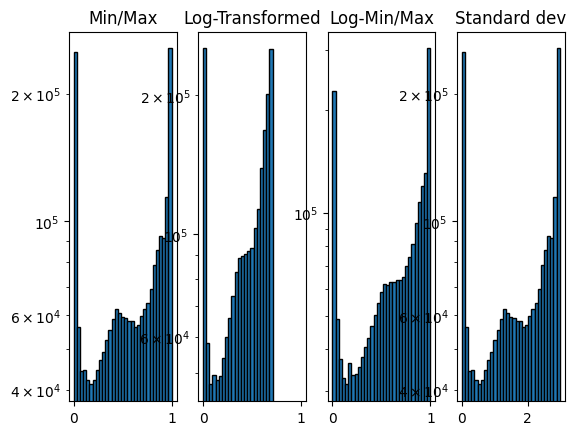

In [5]:
# Standardisation
year = 2010
df_raw = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/raw_'+str(year)+'.csv')
X_train = df_raw['fsdrad'].values
len_X, = X_train.shape

min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train.reshape(len_X,1))

#create log-transformed data
X_log = np.log(X_train_minmax+1)
scaler = StandardScaler()
#scaled_features = scaler.fit_transform(X_standardized)

X_log_minmax = min_max_scaler.fit_transform(X_log.reshape(len_X,1))

X_sd = X_train.reshape(-1)/np.std(X_train.reshape(-1))
#define grid of plots

fig, axs = plt.subplots(nrows=1, ncols=4)

#create histograms

axs[0].hist(X_train_minmax, edgecolor='black',bins=31,log=True,range=[0, 1])
axs[1].hist(X_log, edgecolor='black',bins=31,log=True,range=[0, 1])
axs[2].hist(X_log_minmax, edgecolor='black',bins=31,log=True,range=[0, 1])
axs[3].hist(X_sd, edgecolor='black',bins=31,log=True)#,range=[0, 1])


#add title to each histogram
axs[0].set_title('Min/Max')
axs[1].set_title('Log-Transformed')
axs[2].set_title('Log-Min/Max')
axs[3].set_title('Standard dev')
    


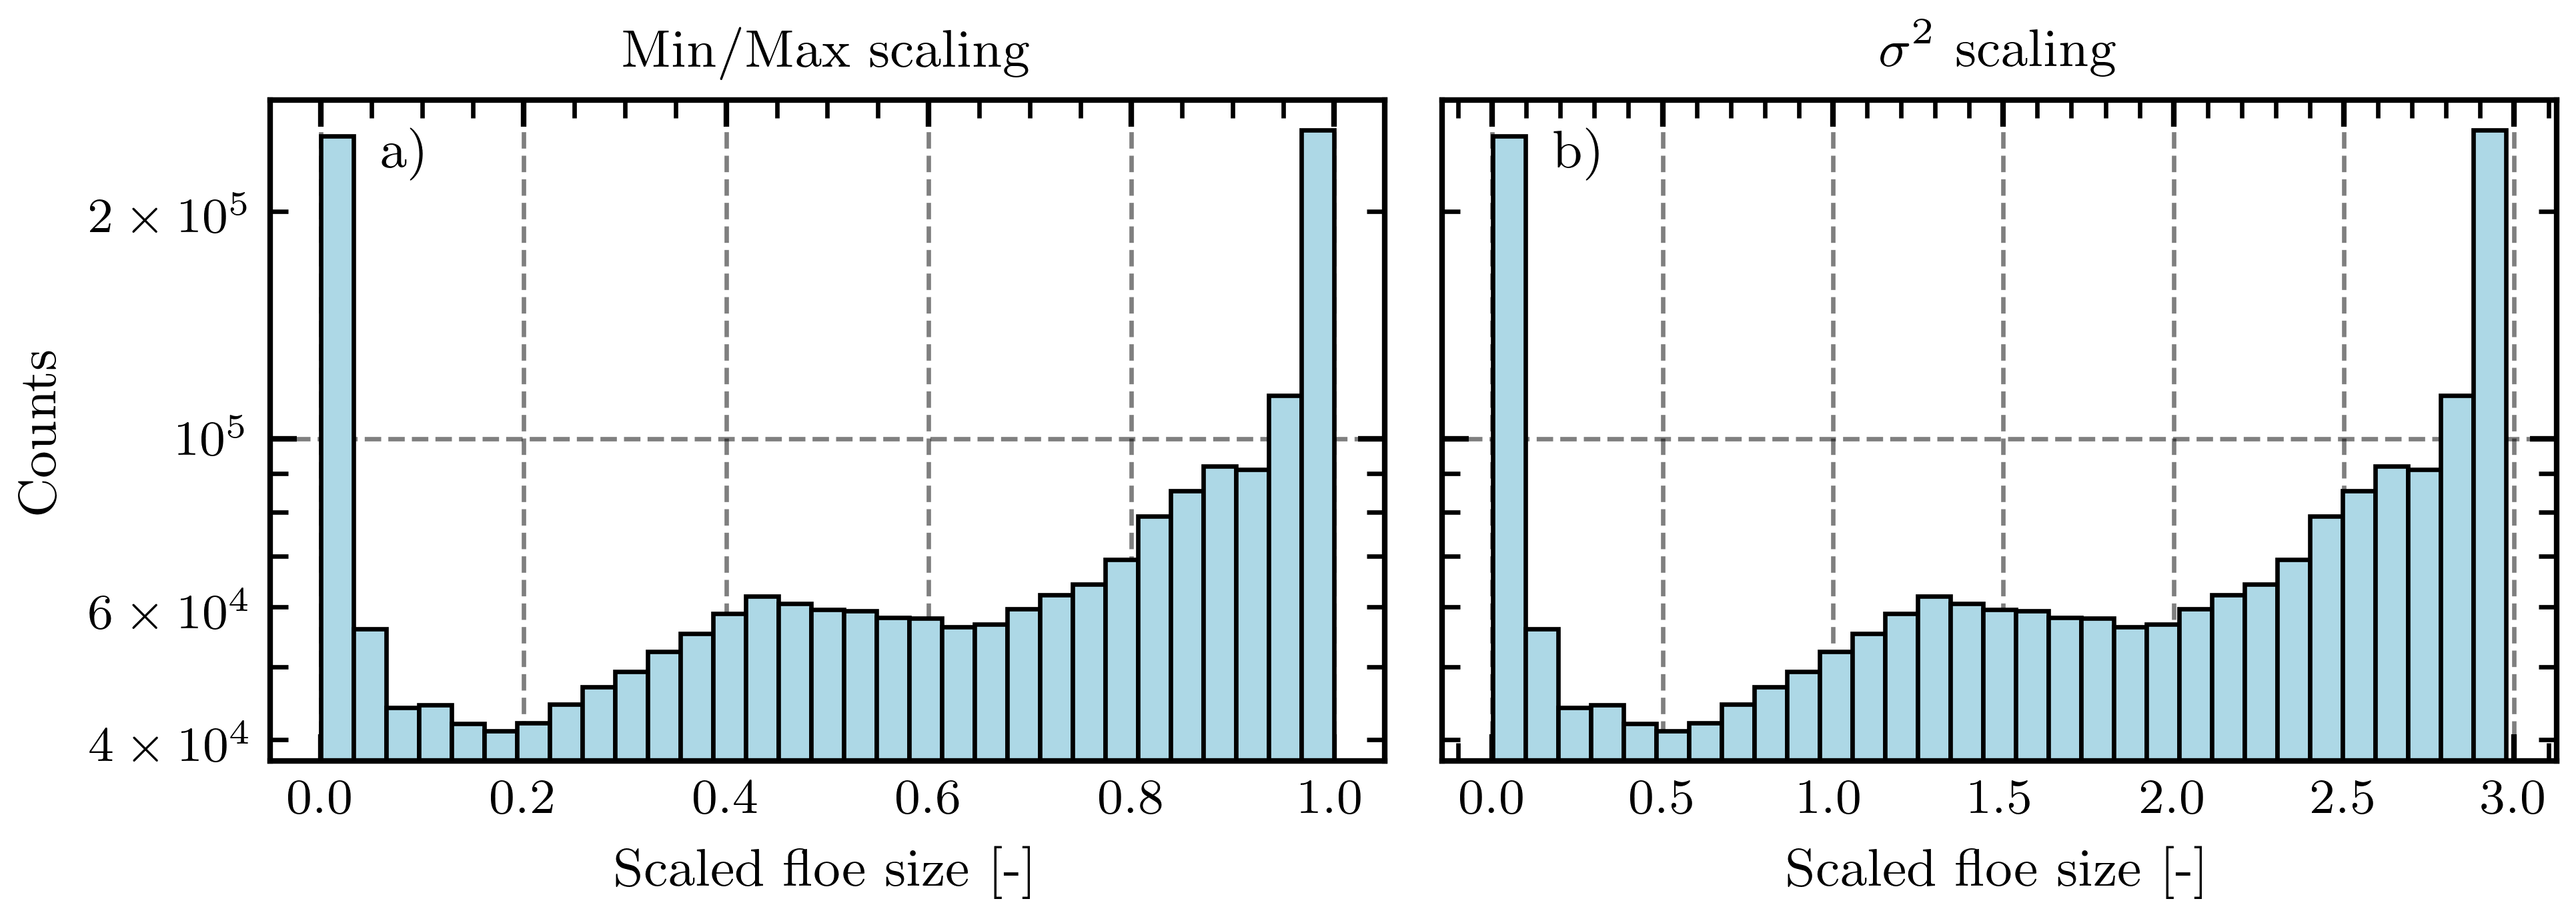

In [26]:
# Plot settings
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
textwidth = 3.31314*2
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio

#plt.style.use("seaborn")
plt.style.use('default')
plt.style.use(['science','ieee', 'grid'])
sns.set_context("paper")
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(width,height/2))
axs[0].hist(X_train_minmax, edgecolor='black',bins=31,log=True,range=[0, 1], color = "lightblue")
axs[1].hist(X_sd, edgecolor='black',bins=31,log=True, color = "lightblue")#,range=[0, 1])


#add title to each histogram
axs[0].set_title('Min/Max scaling')
axs[1].set_title('$\sigma^2$ scaling')
axs[0].set_ylabel('Counts')
#axs[0].set_ylim((1,3*10**5))
axs[0].set_xlabel('Scaled floe size [-]')
axs[1].set_xlabel('Scaled floe size [-]')

trans = mtransforms.ScaledTranslation(20/72, -5/72, fig.dpi_scale_trans)

axs[0].text(0.0, 1.0, 'a)', transform=axs[0].transAxes + trans,
       fontsize='medium', verticalalignment='top', fontfamily='serif',
       bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

axs[1].text(0.0, 1.0, 'b)', transform=axs[1].transAxes + trans,
       fontsize='medium', verticalalignment='top', fontfamily='serif',
       bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

savepath = '/home/566/nd0349/notebooks/'
plt.tight_layout()
plt.savefig(savepath+'scaling_comparison'+str(year)+'.png', dpi = 300) 

## 2b. Calculate the number of rows in all dataframes

In [ ]:
#year = 2019
sum_size = 0
year_range = range(2010,2016)
for year in tqdm(year_range):
    df_raw = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/raw_'+str(year)+'.csv')
    rows,tmp = df_raw.shape
    sum_size += rows

#df_raw.describe()


In [4]:
print(sum_size)

21153080


## 2c. Scale the data

In [5]:
# Standardise the variables
year_range = range(2016,2020)
for year in tqdm(year_range):
    var_name = 'static'
    variable_list = get_var_list(var_name)
    num_variables = np.size(variable_list)
    mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
    savepath = '/home/566/nd0349/notebooks/'
    
    df_raw = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/raw_'+str(year)+'.csv')
    df_standard = standardise(df_raw)
    savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
    savefilename = 'standard_'+str(year)+'.csv'
    df_standard.to_csv(savepath+savefilename)

df_standard.describe()

100%|██████████| 4/4 [01:26<00:00, 21.54s/it]


,aice,hi,hs,fsdrad,iage,alvl,longitude,latitude
count,2.255029e+06,2.255029e+06,2.255029e+06,2.255029e+06,2.255029e+06,2.255029e+06,2.255029e+06,2.255029e+06
mean,9.298539e-01,1.754891e-01,1.072296e-01,6.022793e-01,6.503326e-02,7.295344e-01,2.053656e+02,-6.822305e+01
std,1.765790e-01,1.065633e-01,1.000766e-01,3.388136e-01,4.841989e-02,2.273874e-01,1.011802e+02,5.307262e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01,-7.762990e+01
25%,9.776371e-01,9.182951e-02,3.050119e-02,3.339628e-01,2.814332e-02,6.104934e-01,1.505000e+02,-7.243740e+01
50%,9.986314e-01,1.646212e-01,7.857518e-02,6.696927e-01,5.472223e-02,7.979747e-01,2.095000e+02,-6.822556e+01
75%,9.996538e-01,2.414145e-01,1.546375e-01,9.226012e-01,9.123391e-02,9.059990e-01,3.045000e+02,-6.444659e+01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.595000e+02,-5.220493e+01


# 3. Cluster the data

In [2]:
# Cluster
year_range = range(2019,2020)
for year in tqdm(year_range):
    df_raw = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/raw_'+str(year)+'.csv')
    df_standard = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/standard_'+str(year)+'.csv')
    df_kmeans = kmeans_cluster(df_raw, df_standard)
    savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
    savefilename = 'kmeans_'+str(year)+'.csv'
    df_kmeans.to_csv(savepath+savefilename)


df_kmeans.groupby('k').describe()

  0%|          | 0/1 [00:00<?, ?it/s]

[[0.76306007 0.04041951 0.02538844 0.02783396 0.05290037]
 [0.96479608 0.11019326 0.10738233 0.26478933 0.07206991]
 [0.96413898 0.18858583 0.14985236 0.82837526 0.10536767]]


100%|██████████| 1/1 [00:33<00:00, 33.19s/it]


Unnamed: 0                                                             \
       count          mean            std     min        25%        50%   
k                                                                         
0   285724.0  9.041623e+05  681289.618981  1039.0  327699.75   735042.5   
1   597638.0  9.915762e+05  517100.920129  1036.0  560384.25   939863.5   
2  1371667.0  1.233267e+06  673686.736028     0.0  663274.50  1323710.0   

                               aice            ... longitude         \
          75%        max      count      mean  ...       75%    max   
k                                              ...                    
0  1391236.25  2255028.0   285724.0  0.735467  ...     264.5  359.5   
1  1389774.75  2255004.0   597638.0  0.984471  ...     261.5  359.5   
2  1826131.50  2255000.0  1371667.0  0.946549  ...     313.5  359.5   

    latitude                                                                 \
       count       mean       std      min        25%        50%        75%   
k                                                                             
0   285724.0 -63.929194  4.704778 -77.6299 -67.220250 -64.446594 -60.614490   
1   597638.0 -65.469437  4.637926 -77.6299 -69.173546 -65.601395 -61.953148   
2  1371667.0 -70.317233  4.560052 -77.6299 -74.108920 -70.905850 -67.220250   

              
         max  
k             
0 -52.204933  
1 -52.204933  
2 -53.858738  

[3 rows x 72 columns]

In [8]:
df_kmeans.groupby('k').mean()

/jobfs/95595883.gadi-pbs/ipykernel_813703/1355168923.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_kmeans.groupby('k').mean()


,Unnamed: 0,aice,hi,hs,fsdrad,iage,alvl,longitude,latitude
k,,,,,,,,,
0,8.612601e+05,0.718421,0.051886,0.023956,0.026981,0.057368,0.695633,183.920146,-63.547218
1,7.543197e+05,0.983832,0.112178,0.085968,0.302869,0.053575,0.871086,185.458426,-65.708249
2,1.137143e+06,0.956004,0.236203,0.156007,0.841104,0.095426,0.741461,219.889748,-70.484067


# 4. Map to NetCDF files

In [3]:
# Map to a netCDF
for year in tqdm(year_range):
    df_kmeans = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/kmeans_'+str(year)+'.csv')
    savefilename='/g/data/ia40/sea-ice-classification/kmean_'+str(year)+'.nc'
    mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
    map_to_netcdf(df_kmeans,savefilename,mypath,year)

  0%|          | 0/1 [00:00<?, ?it/s]

Progress: [####################] 100% 
Progress: [####################] 100% 


100%|██████████| 1/1 [19:49<00:00, 1189.39s/it]


In [15]:
#unique_dates = df_kmeans.date
print(year)
unique_dates = df_kmeans['date'].unique()
tmp1, = unique_dates.shape
tmp1

2012


295

In [17]:
df_raw = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/standard_'+str(year)+'.csv')
unique_dates = df_raw['date'].unique()
tmp1, = unique_dates.shape
tmp1

366

In [ ]:
#datetime.now().strftime('%Y-%m-%d %H')
savefilename='/g/data/ia40/sea-ice-classification/kmean_'+str(year)+'.nc'
savefilename

# 5. Create analysis variables datasets

In [7]:
# Analysis variables
var_name = 'analysis'
variable_list = get_var_list(var_name)
num_variables = np.size(variable_list)

savepath = '/home/566/nd0349/notebooks/'
mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
#year = 2019
year_range = range(2013,2020)

for year in tqdm(year_range):
    df = cice_netcdf_to_df(mypath, year)
    savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
    savefilename = 'analysis_raw_'+str(year)+'.csv'
    df.to_csv(savepath+savefilename)


  0%|          | 0/7 [00:00<?, ?it/s]

2013
Progress: [####################] 100% 
(7009799, 1)


 14%|█▍        | 1/7 [13:38<1:21:52, 818.83s/it]

2014
Progress: [####################] 100% 
(7062896, 1)


 29%|██▊       | 2/7 [30:09<1:16:40, 920.05s/it]

2015
Progress: [####################] 100% 
(7114547, 1)


 43%|████▎     | 3/7 [48:46<1:07:20, 1010.03s/it]

2016
Progress: [####################] 100% 
(7007704, 1)


 57%|█████▋    | 4/7 [1:00:46<44:46, 895.34s/it] 

2017
Progress: [####################] 100% 
(6803679, 1)


 71%|███████▏  | 5/7 [1:17:02<30:49, 924.54s/it]

2018
Progress: [####################] 100% 
(6956045, 1)


 86%|████████▌ | 6/7 [1:32:21<15:22, 922.46s/it]

2019
Progress: [####################] 100% 
(6927029, 1)


100%|██████████| 7/7 [1:42:48<00:00, 881.26s/it]


In [9]:
#df.describe()
variable_list = ['dafsd_latm','dafsd_latg','dafsd_weld','dafsd_newi','dafsd_wave']
num_variables = np.size(variable_list)

savepath = '/home/566/nd0349/notebooks/'
mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
year = 2019

NFSD = np.asarray([2.6884, 9.7984, 21.6721, 40.7349, 70.1407, 113.6938, 175.5771, 259.8365, 369.6202, 506.2401, 668.2091, 850.4769])
floe_binwidth = np.asarray([5.2438, 8.9763, 14.7711, 23.3545, 35.4569, 51.6493, 72.1173, 96.4015, 123.1658, 150.0741, 173.8638, 190.6719])


os.chdir(mypath)
file_dates = []
print(year)
filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'

onlyfiles = glob.glob("{path}/iceh.*{year}*".format(path=mypath, year=year))
onlyfiles.sort()
print(filename)
ds = xr.open_dataset(filename)
LN = ds.TLON.values
LT = ds.TLAT.values

data4d = ds['afsdn'][:,:,:,:]
data4d.shape

2019
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-01-01.nc


(5, 12, 300, 360)

# 6. Create dafsd/dt datasets

In [8]:
# DAFSD terms

variable_list = ['dafsd_latm','dafsd_latg','dafsd_weld','dafsd_newi','dafsd_wave']
num_variables = np.size(variable_list)

savepath = '/home/566/nd0349/notebooks/'
mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
year = 2019
NFSD = np.asarray([2.6884, 9.7984, 21.6721, 40.7349, 70.1407, 113.6938, 175.5771, 259.8365, 369.6202, 506.2401, 668.2091, 850.4769])
floe_binwidth = np.asarray([5.2438, 8.9763, 14.7711, 23.3545, 35.4569, 51.6493, 72.1173, 96.4015, 123.1658, 150.0741, 173.8638, 190.6719])

year_range = range(2010,2020)
for year in year_range:
    os.chdir(mypath)
    file_dates = []
    print(year)
    filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'

    onlyfiles = glob.glob("{path}/iceh.*{year}*".format(path=mypath, year=year))
    onlyfiles.sort()
    print(filename)
    ds = xr.open_dataset(filename)
    LN = ds.TLON.values
    LT = ds.TLAT.values
    # Get the total number of grid points
    size = 1
    for dim in np.shape(LN): size *= dim
    aice_data = ds['aice'][0,:,:]
    mask1 = np.ma.masked_where(LT > 0.0, aice_data)
    mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
    master_mask = mask1.mask | mask2.mask
    mask = master_mask

    X_out =  np.ma.masked_array(np.empty((size,1)), mask=mask)

    # Loop over the files in that year
    for filecount, file in enumerate(onlyfiles):
        progressBar = "\rProgress: " + ProgressBar(len(onlyfiles), filecount+1, 20, '#', '.')
        ShowBar(progressBar)

        # Open the file
        filename = file
        file_dates.append(np.datetime64(file[-13:-3]))
        ds = xr.open_dataset(filename)

        # Get and apply masks to remove the ocean
        aice_data = ds['aice'][0,:,:]
        mask1 = np.ma.masked_where(LT > 0.0, aice_data)
        mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
        master_mask = mask1.mask | mask2.mask
        mask = master_mask
        
        aice = np.ma.masked_where(mask, aice_data)

        # Get all the variables
        for counter, exp in enumerate(variable_list):
            data3d = ds[exp][0,:,:,:]
            data = np.zeros(LN.shape)
            for nf in range(0,len(floe_binwidth)):
                data += data3d[nf,:,:].values*NFSD[nf]/aice[:,:]

            data_masked = np.ma.masked_where(mask, data)
            data_masked_vec = data_masked.compressed()
            row_length, = data_masked_vec.shape

            if counter == 0: 
                # First file, then initialise X_temp
                X_single_file = data_masked_vec.reshape(row_length,1)
            else:
                # Else just concatenate the new data on
                X_single_file = np.concatenate([X_single_file, data_masked_vec.reshape(row_length,1)],axis=1)

        data4d = ds['afsdn'][:,:,:,:]
        data = np.zeros(LN.shape)
        for nf in range(0,len(floe_binwidth)):
            data += data4d[0,nf,:,:].values*NFSD[nf]/aice[:,:]

            data_masked = np.ma.masked_where(mask, data)
            data_masked_vec = data_masked.compressed()
            row_length, = data_masked_vec.shape
        if counter == 0: 
            # First file, then initialise X_temp
            X_single_file = data_masked_vec.reshape(row_length,1)
        else:
            # Else just concatenate the new data oncl
            X_single_file = np.concatenate([X_single_file, data_masked_vec.reshape(row_length,1)],axis=1)


        # Add on the corresponding coordinates
        LN_masked = np.ma.masked_where(mask, LN)
        LN_vec = LN_masked.compressed()
        LT_masked = np.ma.masked_where(mask, LT)
        LT_vec = LT_masked.compressed()
        X_single_file = np.concatenate([X_single_file, LN_vec.reshape(row_length,1), LT_vec.reshape(row_length,1)],axis=1)

        if filecount == 0: 
            # Day 1, then initialise the year file
            X_year = X_single_file
            datetime_vec =  np.tile(np.datetime64(file[-13:-3]),(row_length,1))
        else:
            X_year = np.concatenate([X_year, X_single_file],axis=0)
            datetime_vec = np.concatenate([datetime_vec, np.tile(np.datetime64(file[-13:-3]),(row_length,1))],axis=0)
    # Save as dataframe
    df_raw = pd.DataFrame(X_year, columns = variable_list+['pancake','longitude','latitude'])#,'date'])
    df_raw['date'] = datetime_vec
    print(datetime_vec.shape)
    df_raw = df_raw.dropna()
    savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
    savefilename = 'analysis_fsd_raw_'+str(year)+'.csv'
    df_raw.to_csv(savepath+savefilename)

2010
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2010-01-01.nc
Progress: [####################] 100% 
(6943836, 1)
2011
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2011-01-01.nc
Progress: [####################] 100% 
(6983658, 1)
2012
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2012-01-01.nc
Progress: [####################] 100% 
(6998978, 1)
2013
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2013-01-01.nc
Progress: [####################] 100% 
(7009799, 1)
2014
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2014-01-01.nc
Progress: [####################] 100% 
(7062896, 1)
2015
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2015-01-01.nc
Progress: [####################] 100% 
(7114547, 1)
2016
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2016-01-01.nc
Progress: [####################] 100% 
(7007704, 1)
2017
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2017-01-01.nc
Progress: [####################] 100% 
(6803679, 1)
2018
/g/data/ia40/cice-dirs/runs

In [4]:
savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
savefilename = 'analysis_fsd_raw_'+str(year)+'.csv'
df_raw.to_csv(savepath+savefilename)

In [15]:
data

<xarray.DataArray 'wave_sig_ht' (nj: 300, ni: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2010-01-02
    TLON     (nj, ni) float32 80.5 81.5 82.5 83.5 ... 79.94 79.96 79.97 79.99
    TLAT     (nj, ni) float32 -77.88 -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    ULON     (nj, ni) float32 ...
    ULAT     (nj, ni) float32 ...
Dimensions without coordinates: nj, ni
Attributes:
    units:          m
    long_name:      significant height of wind and swell waves
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

## 6a. Map dafsd/dt data to NetCDFs

In [9]:
#def map_to_netcdf(df_kmeans,savefilename,mypath,year):
year_range = range(2010, 2020)
for year in tqdm(year_range):
    df_kmeans = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/kmeans_'+str(year)+'.csv')
    df_dafsd = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/analysis_fsd_raw_'+str(year)+'.csv')
    df_kmeans['pancake'] = df_dafsd['pancake']
    mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
    
    os.chdir(mypath)
    filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'
    onlyfiles = glob.glob("{path}/iceh.*{year}*".format(path=mypath, year=year))
    onlyfiles.sort()
    
    filename = '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2000-01-01.nc'
    ds = xr.open_dataset(filename)
    LN = ds.TLON.values
    LT = ds.TLAT.values
    
    unique_dates = df_kmeans['date'].unique()
    tmp1, = unique_dates.shape
    
    tmp2, tmp3 = LN.shape
    k_means_array = np.empty((tmp1,tmp2,tmp3))
    k_means_array[:] = np.nan
    
    date_length, = unique_dates.shape
    # Map the k values onto the grid
    for time_lp, date_tmp in enumerate(unique_dates):
        progressBar = "\rProgress: " + ProgressBar(date_length, time_lp+1, 20, '#', '.')
        ShowBar(progressBar)
        date_idx = df_kmeans['date'] == date_tmp
    
        lon = df_kmeans['longitude'][date_idx];
        lat = df_kmeans['latitude'][date_idx];
        k = df_kmeans['k'][date_idx];
    
        row_length = date_idx.sum()
        lon = lon.values.reshape(row_length,1)
        lat = lat.values.reshape(row_length,1)
        k = k.values.reshape(row_length,1)
        for row_lp in range(0, row_length):
            a = abs(LT-lat[row_lp])+abs(LN-lon[row_lp])
            i,j = np.unravel_index(a.argmin(),a.shape)
            k_means_array[time_lp,i,j] = k[row_lp]
    
    # Training variables for k-means
    aice_array = np.empty((tmp1,tmp2,tmp3))
    hi_array = np.empty((tmp1,tmp2,tmp3))
    hs_array = np.empty((tmp1,tmp2,tmp3))
    fsdrad_array = np.empty((tmp1,tmp2,tmp3))
    iage_array = np.empty((tmp1,tmp2,tmp3))
    alvl_array = np.empty((tmp1,tmp2,tmp3))
    
    # Extra variables of interest
    swh_array = np.empty((tmp1,tmp2,tmp3))
    pancake_array = np.empty((tmp1,tmp2,tmp3))
    ppd_array = np.empty((tmp1,tmp2,tmp3))
    
    
    date_length, = unique_dates.shape
    
    for filecount, file in enumerate(onlyfiles):
        filename = file
        progressBar = "\rProgress: " + ProgressBar(date_length, filecount+1, 20, '#', '.')
        ShowBar(progressBar)
    
        ds = xr.open_dataset(filename)
        LN = ds.TLON.values
        LT = ds.TLAT.values
    
        aice_data = ds['aice'][0,:,:]
    
        mask1 = np.ma.masked_where(LT > 0.0, aice_data)
        mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
        master_mask = mask1.mask | mask2.mask
        mask = master_mask
    
        data = ds['aice'][0,:,:]
        aice_array[filecount,:,:] = data
        aice_array[filecount,mask] = np.nan
    
        data = ds['hi'][0,:,:]
        hi_array[filecount,:,:] = data
        hi_array[filecount,mask] = np.nan
    
        data = ds['hs'][0,:,:]
        hs_array[filecount,:,:] = data
        hs_array[filecount,mask] = np.nan
    
        data = ds['fsdrad'][0,:,:]
        fsdrad_array[filecount,:,:] = data
        fsdrad_array[filecount,mask] = np.nan
    
        data = ds['iage'][0,:,:]
        iage_array[filecount,:,:] = data
        iage_array[filecount,mask] = np.nan
    
        data = ds['alvl'][0,:,:]
        alvl_array[filecount,:,:] = data
        alvl_array[filecount,mask] = np.nan
    
        # Extra variables of interest
        data = ds['wave_sig_ht'][0,:,:]
        swh_array[filecount,:,:] = data
        swh_array[filecount,mask] = np.nan
    
        #data = ds['pancake'][0,:,:]
        #pancake_array[filecount,:,:] = data
        #pancake_array[filecount,mask] = np.nan
    
        data = ds['peak_period'][0,:,:]
        ppd_array[filecount,:,:] = data
        ppd_array[filecount,mask] = np.nan
    
    # Save to netCDF
    ds = xr.open_dataset(filename)
    HTE = ds.HTE.values
    HTN = ds.HTN.values
    tarea = ds.tarea.values
    tmask = ds.tmask.values
    
    d_vars = {"k" : (['time','nj','ni'],k_means_array,
                                  {'long_name' :"k-means_clusters",
                                   'units'     :"cluster number",
                                   '_FillValue':-2e8}),
              "aice" : (['time','nj','ni'],aice_array,
                                  {'long_name' :"Areal sea ice area proportion of cell",
                                   'units'     :"-",
                                   '_FillValue':-2e8}),
              "hi" : (['time','nj','ni'],hi_array,
                                  {'long_name' :"Grid cell mean ice thickness",
                                   'units'     :"m",
                                   '_FillValue':-2e8}),
              "hs" : (['time','nj','ni'],hs_array,
                                  {'long_name' :"Grid cell mean snow thickness",
                                   'units'     :"m",
                                   '_FillValue':-2e8}),
              "fsdrad" : (['time','nj','ni'],fsdrad_array,
                                  {'long_name' :"Representative floe radius",
                                   'units'     :"m",
                                   '_FillValue':-2e8}),
              "iage" : (['time','nj','ni'],iage_array,
                                  {'long_name' :"Sea ice age",
                                   'units'     :"m",
                                   '_FillValue':-2e8}),
              "alvl" : (['time','nj','ni'],alvl_array,
                                  {'long_name' :"Level ice area fraction",
                                   'units'     :"-",
                                   '_FillValue':-2e8}),
              "wave_sig_ht" : (['time','nj','ni'],swh_array,
                                  {'long_name' :"Signficant wave height",
                                   'units'     :"m",
                                   '_FillValue':-2e8}),
              "pancake" : (['time','nj','ni'],pancake_array,
                                  {'long_name' :"Areal SIC in FSTD(1,1)",
                                   'units'     :"-",
                                   '_FillValue':-2e8}),
              "HTE" : (['nj','ni'],HTE,
                              {'long_name':"T cell width on East side",
                               'units'    :"m",
                               '_FillValue':-2e8}),
              "HTN" : (['nj','ni'],HTN,
                              {'long_name':"T cell width on North side",
                               'units'    :"m",
                               '_FillValue':-2e8}),
              "tarea" : (['nj','ni'],tarea,
                              {'long_name':"area of T grid cells",
                               'units'    :"m^2",
                               '_FillValue':-2e8}),
              "tmask" : (['nj','ni'],tmask,
                              {'long_name':"ocean grid mask",
                               'units'    :"Boolean",
                               '_FillValue':-2e8})}
    
    coords = {"LON"  : (["nj","ni"],LN,{'units':'degrees_east'}),
              "LAT"  : (["nj","ni"],LT,{'units':'degrees_north'}),
              "time" : (["time"],unique_dates)}
    attrs = {'creation_date': "2023-09-26",#datetime.now().strftime('%Y-%m-%d %H'),
             'conventions'  : "",
             'title'        : "k-means clusters for CICE-WIM standalone 1-degree data",
             'source'       : ", ",
             'comment'      : "",
             'author'       : 'Noah Day',
             'email'        : 'noah.day@adelaide.edu.au'}
    enc_dict  = {'shuffle':True,'zlib':True,'complevel':5} 
    nc_out = xr.Dataset(data_vars=d_vars,coords=coords,attrs=attrs)
    write_job = nc_out.to_netcdf(savefilename,unlimited_dims=['time'],compute=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Progress: [####################] 100% 
Progress: [####################] 100% 


 10%|█         | 1/10 [19:58<2:59:44, 1198.32s/it]

Progress: [####################] 100% 
Progress: [####################] 100% 


 10%|█         | 1/10 [40:07<6:01:03, 2407.07s/it]


PermissionError: [Errno 13] Permission denied: b'/g/data/ia40/cice-dirs/runs/waves-10/history/analysis_fsd_raw_2019.csv'

In [42]:
np.zeros(LN.shape)
filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'
print(filename)
#xr.open_dataset(filename)
#data3d[:,:,nf].values*floe_binwidth[nf]

#data += data3d[:,:,nf]*floe_binwidth[nf]
print(floe_binwidth[nf])
print(data)
print(data3d[nf,:,:].shape)
print(np.dot(data3d[:,:,nf].values, floe_binwidth[nf]))
data = data + np.dot(data3d[nf,:,:].values, floe_binwidth[nf])


/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2018-01-01.nc
5.2438
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(300, 360)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


ValueError: operands could not be broadcast together with shapes (300,360) (12,300) 

# 7. Create the forcing dataset

In [3]:
# Analysis dataset
variable_list = ['uvel','vvel','wave_sig_ht','peak_period','Tair','sst','sss','strairx','strairy','strocnx','strocny','strcorx','strcory','strtltx','strtlty','strintx','strinty','strength','divu','shear','uatm','vatm','uocn','vocn','frzmlt','daidtd','daidtt','meltt','meltb','meltl','Tsfc','sice','uatm','vatm','frazil','congel','dagedtt','dagedtd']
num_variables = np.size(variable_list)

savepath = '/home/566/nd0349/notebooks/'
mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
#year = 2011

NFSD = np.asarray([2.6884, 9.7984, 21.6721, 40.7349, 70.1407, 113.6938, 175.5771, 259.8365, 369.6202, 506.2401, 668.2091, 850.4769])
floe_binwidth = np.asarray([5.2438, 8.9763, 14.7711, 23.3545, 35.4569, 51.6493, 72.1173, 96.4015, 123.1658, 150.0741, 173.8638, 190.6719])
year_range = range(2011,2020)
for year in tqdm(year_range):    
    os.chdir(mypath)
    file_dates = []
    #print(year)
    filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'
    
    onlyfiles = glob.glob("{path}/iceh.*{year}*".format(path=mypath, year=year))
    onlyfiles.sort()
    #print(filename)
    ds = xr.open_dataset(filename)
    LN = ds.TLON.values
    LT = ds.TLAT.values
    # Get the total number of grid points
    size = 1
    for dim in np.shape(LN): size *= dim
    aice_data = ds['aice'][0,:,:]
    mask1 = np.ma.masked_where(LT > 0.0, aice_data)
    mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
    master_mask = mask1.mask | mask2.mask
    mask = master_mask
    
    X_out =  np.ma.masked_array(np.empty((size,1)), mask=mask)
    
    # Loop over the files in that year
    for filecount, file in enumerate(onlyfiles): #, total = len(onlyfiles),
                  #desc ="Reading in data"):
        #progressBar = "\rProgress: " + ProgressBar(len(onlyfiles), filecount+1, 20, '#', '.')
        #ShowBar(progressBar)
    
        # Open the file
        filename = file
        file_dates.append(np.datetime64(file[-13:-3]))
        ds = xr.open_dataset(filename)
    
        # Get and apply masks to remove the ocean
        aice_data = ds['aice'][0,:,:]
        mask1 = np.ma.masked_where(LT > 0.0, aice_data)
        mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
        master_mask = mask1.mask | mask2.mask
        mask = master_mask
    
        # Get all the variables
        for counter, exp in enumerate(variable_list):
            data = ds[exp][0,:,:]
            data_masked = np.ma.masked_where(mask, data)
            data_masked_vec = data_masked.compressed()
            row_length, = data_masked_vec.shape
    
            if counter == 0: 
                # First file, then initialise X_temp
                X_single_file = data_masked_vec.reshape(row_length,1)
            else:
                # Else just concatenate the new data on
                X_single_file = np.concatenate([X_single_file, data_masked_vec.reshape(row_length,1)],axis=1)
    
        
        
        # Add on the corresponding coordinates
        LN_masked = np.ma.masked_where(mask, LN)
        LN_vec = LN_masked.compressed()
        LT_masked = np.ma.masked_where(mask, LT)
        LT_vec = LT_masked.compressed()
        X_single_file = np.concatenate([X_single_file, LN_vec.reshape(row_length,1), LT_vec.reshape(row_length,1)],axis=1)
    
        if filecount == 0: 
            # Day 1, then initialise the year file
            X_year = X_single_file
            datetime_vec =  np.tile(np.datetime64(file[-13:-3]),(row_length,1))
        else:
            X_year = np.concatenate([X_year, X_single_file],axis=0)
            datetime_vec = np.concatenate([datetime_vec, np.tile(np.datetime64(file[-13:-3]),(row_length,1))],axis=0)
    # Save as dataframe
    df_raw = pd.DataFrame(X_year, columns = variable_list+['longitude','latitude'])#,'date'])
    df_raw['date'] = datetime_vec
    print(datetime_vec.shape)
    df_raw = df_raw.dropna()
    
    savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
    savefilename = 'forcing_analysis_'+str(year)+'.csv'
    df_raw.to_csv(savepath+savefilename)

  0%|          | 0/9 [00:00<?, ?it/s]

(6983658, 1)


 11%|█         | 1/9 [05:05<40:45, 305.68s/it]

(6998978, 1)


 22%|██▏       | 2/9 [10:01<35:01, 300.15s/it]

(7009799, 1)


 33%|███▎      | 3/9 [14:54<29:38, 296.46s/it]

(7062896, 1)


 44%|████▍     | 4/9 [19:52<24:47, 297.41s/it]

(7114547, 1)


 56%|█████▌    | 5/9 [25:43<21:06, 316.62s/it]

(7007704, 1)


 67%|██████▋   | 6/9 [31:16<16:06, 322.20s/it]

(6803679, 1)


 78%|███████▊  | 7/9 [36:43<10:47, 323.63s/it]

(6956045, 1)


 89%|████████▉ | 8/9 [42:32<05:31, 331.90s/it]

(6927029, 1)


100%|██████████| 9/9 [48:10<00:00, 321.12s/it]


# 8. Cluster without floe size data

In [4]:
# Without floe size
year = 2019
df_raw = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/raw_'+str(year)+'.csv')
df_standard = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/standard_'+str(year)+'.csv')


#init_centroids_good = np.array([[0.76306007, 0.04041951, 0.02538844, 0.02783396, 0.05290037, 0.74416677],
#                                    [0.96479608, 0.11019326, 0.10738233, 0.26478933, 0.07206991, 0.80610988],
#                                    [0.96413898, 0.18858583, 0.14985236, 0.82837526, 0.10536767, 0.74644532]])
kmeans = KMeans(
    init='random',
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=2020
)

# Take a sub-sample (same number of points for each date)
#df_temp = df_standard.drop(df_raw[df_raw.aice < 0.01].index)
#df_subsample = df_temp.groupby('date', group_keys=False).apply(lambda x: x.sample(500))
#X_train = df_subsample.iloc[:, 1:6] 

X_train = df_standard.iloc[:, [1, 2, 3, 5, 6]] 
predicted = kmeans.fit(X_train)
#kmeans.cluster_centers_ = init_centroids_good


predicted = kmeans.predict(X_train) 
print(kmeans.cluster_centers_)
df_kmeans = df_standard
df_kmeans['k'] = predicted

savefilename = 'kmean_nofsd_'+str(year)+'.csv'
df_kmeans.to_csv(savepath+savefilename)
df_kmeans.groupby('k').describe()

[[0.95234564 0.29785954 0.21163704 0.10362664 0.51804689]
 [0.98303856 0.13485998 0.07432438 0.04505734 0.86435835]
 [0.379072   0.10346347 0.03017894 0.10579448 0.28142671]]


Unnamed: 0                                                          \
       count          mean            std   min       25%        50%   
k                                                                      
0   592827.0  1.280413e+06  711383.912391   0.0  689519.5  1447772.0   
1  1493851.0  1.060966e+06  562724.981203  32.0  580087.5  1031020.0   
2   168351.0  1.179603e+06  979792.187843   8.0   97273.5  1559091.0   

                              aice            ... longitude          latitude  \
         75%        max      count      mean  ...       75%    max      count   
k                                             ...                               
0  1913931.0  2254988.0   592827.0  0.952330  ...     276.5  359.5   592827.0   
1  1521154.5  2254786.0  1493851.0  0.983008  ...     310.5  359.5  1493851.0   
2  2170876.5  2255028.0   168351.0  0.379045  ...     264.5  359.5   168351.0   

                                                                           
        mean       std      min       25%       50%        75%        max  
k                                                                          
0 -70.121258  4.013980 -77.6299 -73.13569 -70.90585 -67.220250 -53.858738  
1 -67.592500  5.570619 -77.6299 -72.07202 -67.73019 -63.846264 -52.204933  
2 -67.133891  5.272063 -77.6299 -70.90585 -67.22025 -63.846264 -52.204933  

[3 rows x 72 columns]

In [43]:
predicted.shape
df_kmeans.shape

(2104612, 11)

In [5]:
# Map to a netCDF
savefilename='/g/data/ia40/sea-ice-classification/kmean_nofsd_'+str(year)+'.nc'
mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
map_to_netcdf(df_kmeans,savefilename,mypath,year)

Progress: [####################] 100% 
Progress: [####################] 100% 


## Number of cluster plots



In [9]:
year = 2019
df_standard = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/standard_'+str(year)+'.csv')
df_standard#[['aice','hi','hs','fsdrad','iage']]

,Unnamed: 0,aice,hi,hs,fsdrad,iage,alvl,longitude,latitude,date
0,0,0.988461,0.536366,0.023633,0.999180,0.042259,0.036633,312.5,-77.629900,2019-01-01
1,1,0.990281,0.447256,0.014449,0.998427,0.045759,0.176249,313.5,-77.629900,2019-01-01
2,2,0.984603,0.438206,0.014121,0.999283,0.049756,0.247173,314.5,-77.629900,2019-01-01
3,3,0.978392,0.438474,0.013214,0.999364,0.051723,0.277140,315.5,-77.629900,2019-01-01
4,4,0.969030,0.442520,0.013791,0.999561,0.052750,0.282632,316.5,-77.629900,2019-01-01
...,...,...,...,...,...,...,...,...,...,...
2255024,2255024,0.182202,0.069318,0.006424,0.002373,0.093507,0.156919,55.5,-59.922382,2019-12-31
2255025,2255025,0.255396,0.081229,0.007502,0.002373,0.093453,0.201854,56.5,-59.922382,2019-12-31
2255026,2255026,0.282651,0.085891,0.007539,0.002373,0.094094,0.217382,57.5,-59.922382,2019-12-31
2255027,2255027,0.250340,0.081930,0.006297,0.002488,0.095243,0.191389,58.5,-59.922382,2019-12-31


In [16]:
# Read in the data
init_centroids_good = np.array([[0.76306007, 0.04041951, 0.02538844, 0.02783396, 0.05290037, 0.74416677],
                                [0.96479608, 0.11019326, 0.10738233, 0.26478933, 0.07206991, 0.80610988],
                                [0.96413898, 0.18858583, 0.14985236, 0.82837526, 0.10536767, 0.74644532]])

init_centroids_good5 = np.array([[0.76306007, 0.04041951, 0.02538844, 0.02783396, 0.05290037],
                                [0.96479608, 0.11019326, 0.10738233, 0.26478933, 0.07206991],
                                [0.96413898, 0.18858583, 0.14985236, 0.82837526, 0.10536767]])

temp_centroids = np.array([[0.84822848, 0.07120881, 0.05316148, 0.08386655, 0.07076581],
                           [0.9705795,  0.17259977, 0.1550262,  0.50894983, 0.10418412],
                           [0.95624177, 0.23711783, 0.17548055, 0.90207538, 0.1257161 ]])

temp_centroids2 = np.array([[0.74822848, 0.07120881, 0.05316148, 0.08386655, 0.07076581],
                           [0.9705795,  0.17259977, 0.1550262,  0.30894983, 0.10418412],
                           [0.95624177, 0.23711783, 0.17548055, 0.90207538, 0.1257161 ]])
# 1,2,4,5 - n_init = 10
# [[0.96933991 0.17684909 0.52236054 0.10476834] 
#  [0.954816   0.24380996 0.90860074 0.1240639 ]
#  [0.84475763 0.0731137  0.08730863 0.07188815]]
centroids_2010_19 = np.array([[0.85022724, 0.06894492, 0.05136532, 0.09140753, 0.06878329],
                              [0.9724085,  0.1677981,  0.15141024, 0.52452823, 0.10017775],
                              [0.95569823, 0.22579207, 0.16465524, 0.91346223, 0.12173907]])
centroids_1234 = np.array([[0.94945654, 0.2515982,  0.2122156,  0.90603441],
                           [0.85210368, 0.0684397,  0.05763854, 0.09083893],
                           [0.97240312, 0.17300001, 0.17728632, 0.51520013]])
centroids_1234_2018 = np.array([[0.8561829,  0.07160749, 0.05312367, 0.0869227 ],
                                [0.9710057,  0.17624316, 0.15780707, 0.51511927],
                                [0.95734083, 0.22890432, 0.16598472, 0.90287841]])

savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
year = 2019
df_raw = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/raw_'+str(year)+'.csv')
df_standard = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/standard_'+str(year)+'.csv')

#df_temp = [pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/standard_'+str(year)+'.csv') for i,year in enumerate(range(2010,2020))]

#df_all = pd.concat(df_temp)
df_all = df_standard#[['aice','hi','hs','fsdrad','iage']]

n_clusters = 3
kmeans = KMeans(
#    init='random',#'k-means++',
#    init=init_centroids_good5,
    init='random',
    n_clusters=n_clusters,
#    n_init=1,
    n_init=10,
    max_iter=100,
    random_state=1,#100,
    algorithm="lloyd",
    #copy_x=True
)
print(str(n_clusters))
# Take a sub-sample (same number of points for each date)
#df_temp = df_standard.drop(df_raw[df_raw.aice < 0.01].index)
#df_subsample = df_temp.groupby('date', group_keys=False).apply(lambda x: x.sample(500))
#X_train = df_subsample.iloc[:, 1:6] 
#year=2018
#df_standard = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/standard_'+str(year)+'.csv')
#df1 = df_standard.iloc[:, [1,2,3,4,5]] 
#year=2019
#df_standard = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/standard_'+str(year)+'.csv')
#df2 = df_standard.iloc[:, [1,2,3,4,5]] 
#data = [df1 , df2]
#X_train = pd.concat(data)
#print(X_train)
X_train = np.asarray(df_all.iloc[:, [1,2,3,5]]) #np.asarray(df_all.iloc[:, [1,2,3,4]])

# Log transform floe size 
# X_temp = np.asarray(df_raw.iloc[:,4])
# min_max_scaler = preprocessing.MinMaxScaler()
# X_train_minmax = min_max_scaler.fit_transform(X_temp.reshape(-1,1))

# #create log-transformed data
# X_log = np.log(X_train_minmax+1)
# X_log_minmax = min_max_scaler.fit_transform(X_log.reshape(-1,1))
# X_train[:,3] = X_log_minmax.reshape(-1,)

predicted = kmeans.fit(X_train)
#tmp_centroids = kmeans.cluster_centers_
#tmp_centroids[1,3] = 0.3
#tmp_centroids[0,0] = 0.7
#kmeans.cluster_centers_ = init_centroids_good5
#kmeans.cluster_centers_ = centroids_2010_19
#kmeans.cluster_centers_ = centroids_1234_2018

predicted = kmeans.predict(X_train) 
print(kmeans.cluster_centers_)

#print(init_centroids_good)
df_kmeans = df_all
df_kmeans['k'] = predicted

savefilename = 'kmean_'+str(n_clusters)+'_clusters_nofloesize_'+str(year)+'.csv'
df_kmeans.to_csv(savepath+savefilename)
#df_kmeans.groupby('k').describe()

#X_train.describe
# print([[0.84373212, 0.0722531,  0.05491366, 0.08718081, 0.07150616],
#        [0.96909368, 0.17405437, 0.15680961, 0.51940893, 0.10357535],
#        [0.95534606, 0.24507633, 0.18365674, 0.90693039, 0.12469178]])

3
[[0.97139309 0.12965276 0.06121123 0.04654208]
 [0.38224682 0.09589192 0.02651568 0.10314115]
 [0.98229221 0.30108276 0.23353668 0.09686239]]


In [14]:
n_clusters = 2
df_read = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/'+'kmean_'+str(n_clusters)+'_clusters_'+str(year)+'.csv')
savefilename='/g/data/ia40/sea-ice-classification/kmean_'+str(n_clusters)+'_clusters_'+str(year)+'.nc'
mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
map_to_netcdf(df_read,savefilename,mypath,year)

Progress: [####################] 100% 
Progress: [####################] 100% 


In [3]:
# Read in the data
init_centroids_good = np.array([[0.76306007, 0.04041951, 0.02538844, 0.02783396, 0.05290037, 0.74416677],
                                [0.96479608, 0.11019326, 0.10738233, 0.26478933, 0.07206991, 0.80610988],
                                [0.96413898, 0.18858583, 0.14985236, 0.82837526, 0.10536767, 0.74644532]])
savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
year = 2019
df_raw = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/raw_'+str(year)+'.csv')
df_standard = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/standard_'+str(year)+'.csv')



df_all = df_standard

n_clusters = 3
kmeans = KMeans(
#    init='random',#'k-means++',
#    init=init_centroids_good5,
    init='random',
    n_clusters=n_clusters,
#    n_init=1,
    n_init=10,
    max_iter=100,
    random_state=1,#100,
    algorithm="lloyd",
    copy_x=True
)
print(str(n_clusters))

#X_train = np.asarray(df_all.iloc[:, [1,2,3,4,5,6]])
df_subsample = df_all.groupby('date', group_keys=False).apply(lambda x: x.sample(500))
X_train = df_subsample.iloc[:, 1:6] 

predicted = kmeans.fit(X_train)
kmeans.cluster_centers_ = init_centroids_good

predicted = kmeans.predict(X_train) 
print(kmeans.cluster_centers_)
#score = silhouette_score (predicted, metric='euclidean')
score = silhouette_score(X_train, predicted)
print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

#print(init_centroids_good)
#df_kmeans = df_all
#df_kmeans['k'] = predicted


3
[[0.76306007 0.04041951 0.02538844 0.02783396 0.05290037 0.74416677]
 [0.96479608 0.11019326 0.10738233 0.26478933 0.07206991 0.80610988]
 [0.96413898 0.18858583 0.14985236 0.82837526 0.10536767 0.74644532]]
For n_clusters = 3, silhouette score is -0.009975723332939758)


In [ ]:
#Use silhouette score
range_n_clusters = list (range(2,10))
print ("Number of clusters from 2 to 9: \n", range_n_clusters)

for n_clusters in range_n_clusters:
    clusterer = KMeans (n_clusters=n_clusters).fit(?)
    preds = clusterer.predict(?)
    centers = clusterer.cluster_centers_

    score = silhouette_score (?, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score)

In [5]:
df_standard.iloc[:, [1,2,3,4,5]]

,aice,hi,hs,fsdrad,iage
0,0.623281,0.318859,0.095338,0.999611,0.103800
1,0.500016,0.229953,0.063062,0.996662,0.110799
2,0.502440,0.226888,0.069519,0.994825,0.127295
3,0.503418,0.231813,0.077900,0.997175,0.138439
4,0.516068,0.238184,0.080287,0.989021,0.143729
...,...,...,...,...,...
2238854,0.118517,0.048255,0.041173,0.002404,0.208808
2238855,0.301688,0.108124,0.046467,0.002679,0.205330
2238856,0.550775,0.170784,0.063531,0.003149,0.206192
2238857,0.438356,0.142143,0.050980,0.002418,0.209632


In [92]:
savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
savefilename = 'kmean_'+str(n_clusters)+'_clusters_new_1234_'+str(year)+'.csv'
df_kmeans.to_csv(savepath+savefilename)

In [95]:
df_read = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/'+'kmean_'+str(n_clusters)+'_clusters_new_1234_'+str(year)+'.csv')
savefilename='/g/data/ia40/sea-ice-classification/kmean_'+str(n_clusters)+'_clusters_new_1234_'+str(year)+'.nc'
mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
map_to_netcdf(df_read,savefilename,mypath,year)

Progress: [####################] 100% 
Progress: [####################] 100% 


In [ ]:
#X_train = df_standard.iloc[:, [1,2,3,4,5]] 
fig, axs = plt.subplots(nrows=1, ncols=3)

#create histograms

axs[0].hist(X_log_minmax, edgecolor='black',bins=31,log=True,range=[0, 1])
axs[1].hist(X_train[:,0], edgecolor='black',bins=31,log=True,range=[0, 1])

Done!


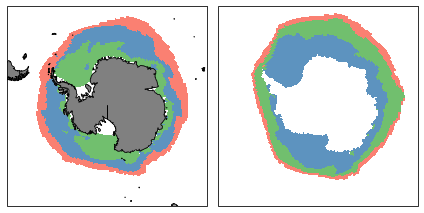

In [89]:
filename = '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2000-01-01.nc'
ds = xr.open_dataset(filename)
LN = ds.TLON.values
LT = ds.TLAT.values
n_clusters = 3
cmap = mpl.colors.ListedColormap([(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])#,'cyan','magenta'])
# define the bins and normalize
bounds = np.linspace(0, n_clusters, n_clusters+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
unique_dates = df_kmeans['date'].unique()
#unique_dates = unique_dates[243]
#tmp1, = unique_dates.shape
tmp1=1

tmp2, tmp3 = LN.shape
k_means_array = np.empty((tmp2,tmp3))
k_means_array[:] = np.nan

#date_length, = unique_dates.shape
date_length = tmp1
# Map the k values onto the grid
#for time_lp, date_tmp in enumerate(unique_dates):
date_tmp = unique_dates[258] # 258 = mid september
#progressBar = "\rProgress: " + ProgressBar(date_length, time_lp+1, 20, '#', '.')
#ShowBar(progressBar)
date_idx = df_kmeans['date'] == date_tmp

lon = df_kmeans['longitude'][date_idx];
lat = df_kmeans['latitude'][date_idx];
k = df_kmeans['k'][date_idx];

row_length = date_idx.sum()
lon = lon.values.reshape(row_length,1)
lat = lat.values.reshape(row_length,1)
k = k.values.reshape(row_length,1)
for row_lp in range(0, row_length):
    a = abs(LT-lat[row_lp])+abs(LN-lon[row_lp])
    i,j = np.unravel_index(a.argmin(),a.shape)
    k_means_array[i,j] = k[row_lp]
print('Done!')


# Plot this on a map        
fontprops = fm.FontProperties(size=18)
plt.figure()
coord_lims = [-180, 180, -50, -90]

readfilename='/g/data/ia40/sea-ice-classification/kmean_2019.nc'
ds = xr.open_dataset(readfilename)
lons = ds['LON'][:,:]
lats = ds['LAT'][:,:]

ax = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent(coord_lims, ccrs.PlateCarree())
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                        edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
p = ax.pcolormesh(lons, lats, k_means_array[:,:],
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
            shading='auto')
#plt.title(str(n_clusters)+" clusters")

readfilename='/g/data/ia40/sea-ice-classification/kmean_2019.nc'
ds = xr.open_dataset(readfilename)
plot_data = ds['k'][258,:,:]
ax = plt.subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())
ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:],  plot_data,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            shading='auto') 
ax.set_extent(coord_lims, ccrs.PlateCarree())


#cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04, label='Cluster number') 
savepath = '/home/566/nd0349/notebooks/'
plt.tight_layout()
#plt.savefig(savepath+'kmeans_map_14_jan'+str(year)+'.png', dpi = 300) 

In [94]:
filename = '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2017-09-15.nc'
ds = xr.open_dataset(filename)
miz_width_array = np.empty((tmp3))
effective_miz_width_array = np.empty((tmp3))
miz_cluster_number = 0
for lon_idx in range(0,tmp3):
        # MIZ width
        miz_idx = k_means_array[:,lon_idx] == miz_cluster_number
        locs = [i for i, x in enumerate(np.diff(miz_idx)) if x]
#        locs[-1]
#        miz_idx[0:locs[-2]] = False
        sic_idx = ds['aice'][0,:,lon_idx].data > 0.15
#        sic_idx = ds['aice'][day_idx,:,lon_idx].data > 0.15
#        miz_idx = miz_idx*sic_idx
#        sic_1580_idx = np.logical_and(sic_idx,ds['aice'][day_idx,:,lon_idx].data < 0.8)
        if not any(miz_idx):
            # If there are no MIZ cells then set distance to 0
            miz_width_array[lon_idx] = 0
            effective_miz_width_array[lon_idx] = 0
            
            
            # miz_upper_boundary[day_idx,lon_idx] = LT[0,lon_idx]
            # miz_lower_boundary[day_idx,lon_idx] = LT[0,lon_idx]
        else:
            miz_width_array[lon_idx] = ds['HTE'][miz_idx,lon_idx].data.sum()
            effective_miz_width_array[lon_idx] = np.multiply(ds['HTE'][miz_idx,lon_idx].data, ds['aice'][0,miz_idx,lon_idx].data).sum()
            
            # locs = np.asarray(miz_idx).nonzero()
            # miz_upper_boundary[day_idx,lon_idx] = LT[locs[0][-1],lon_idx]
            # miz_lower_boundary[day_idx,lon_idx] = LT[locs[0][0],lon_idx]
            
        # if not any(sic_1580_idx):
        #     sic_width_array[day_idx,lon_idx] = 0
        # else:
        #     sic_width_array[day_idx,lon_idx] = ds['HTE'][sic_1580_idx,lon_idx].data.sum()
print(np.nanmean(miz_width_array)/1000)
print(np.nanmean(effective_miz_width_array)/1000)

302.7954365017361
266.4839010416667


In [76]:
locs
#np.diff(miz_idx)

[]

In [60]:
filename = '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-08-25.nc'
ds = xr.open_dataset(filename)
aice_temp = np.squeeze(ds.aice[0,:,:])
#idx = lt < 0
idx = LT < 0
aice = np.multiply(aice_temp,idx)
data_timestep = np.sum(np.multiply(aice,ds.tarea[:,:]))
data_timestep/(10^6)

# 18.40 million km^2

<xarray.DataArray 'aice' ()>
array(1.88102948e+12)
Coordinates:
    time     datetime64[ns] 2019-08-26

In [17]:
# Read in the data
savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
year = 2019
df_raw = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/raw_'+str(year)+'.csv')
df_standard = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/standard_'+str(year)+'.csv')
for n_clusters in [2, 4]: #range(2,5,1):
    kmeans = KMeans(
    init='random',
    n_clusters=n_clusters,
    n_init=10,
    max_iter=300,
    random_state=100,
    algorithm="lloyd",
    copy_x=False
    )
    print(str(n_clusters))
    # Take a sub-sample (same number of points for each date)
    #df_temp = df_standard.drop(df_raw[df_raw.aice < 0.01].index)
    #df_subsample = df_temp.groupby('date', group_keys=False).apply(lambda x: x.sample(500))
    #X_train = df_subsample.iloc[:, 1:6] 

    X_train = df_standard.iloc[:, [1, 2, 3, 4, 5]] 
    predicted = kmeans.fit(X_train)
    #kmeans.cluster_centers_ = init_centroids_good
    sort_idx = kmeans.cluster_centers_[:, 1].argsort()
    kmeans.cluster_centers_ = kmeans.cluster_centers_[sort_idx]

    predicted = kmeans.predict(X_train) 
    print(kmeans.cluster_centers_)
    df_kmeans = df_standard
    df_kmeans['k'] = predicted

    savefilename = 'kmean_'+str(n_clusters)+'_clusters_'+str(year)+'.csv'
    df_kmeans.to_csv(savepath+savefilename)
    df_kmeans.groupby('k').describe()



2
[[0.89770538 0.09730089 0.06066302 0.21218117 0.05037361]
 [0.94845671 0.22073305 0.13417549 0.82801136 0.07351613]]
4
[[0.28885261 0.07428895 0.01689918 0.23730802 0.10195104]
 [0.96474939 0.08080646 0.04987226 0.13793119 0.03942266]
 [0.97362261 0.20356807 0.15105387 0.56512082 0.07399472]
 [0.95709738 0.2190679  0.11864735 0.92057569 0.06825262]]


In [31]:
init_centroids_good = np.array([[0.76306007, 0.04041951, 0.02538844, 0.02783396, 0.05290037, 0.74416677],
                                [0.96479608, 0.11019326, 0.10738233, 0.26478933, 0.07206991, 0.80610988],
                                [0.96413898, 0.18858583, 0.14985236, 0.82837526, 0.10536767, 0.74644532]])
#print(init_centroids_good.sort(axis=1))
#sort_idx = kmeans.cluster_centers[:, 1].argsort()
#kmeans.cluster_centers[sort_idx]

#init_centroids_good
kmeans.cluster_centers_

array([[0.32081291, 0.06698392, 0.02356196, 0.11940035, 0.14216329],
       [0.94998894, 0.07821521, 0.06654588, 0.1205576 , 0.05972605],
       [0.97324214, 0.18570843, 0.16789924, 0.55142934, 0.10862722],
       [0.959956  , 0.24584033, 0.18273814, 0.9138486 , 0.12372801]])

In [4]:
# Convert the dataframes to netcdf
for n_clusters in [2,4]:#range(3,4,1):
    print(str(n_clusters))
    year = 2019
    df_read = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/'+'kmean_'+str(n_clusters)+'_clusters_'+str(year)+'.csv')
    savefilename='/g/data/ia40/sea-ice-classification/kmean_'+str(n_clusters)+'_clusters_'+str(year)+'.nc'
    mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
    map_to_netcdf(df_read,savefilename,mypath,year)

2
Progress: [####################] 100% 
Progress: [####################] 100% 
4
Progress: [####################] 100% 
Progress: [####################] 100% 


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8.5, 5))

for ax in axes.flat:
    ax.set_axis_off()
#    im = ax.imshow(np.random.random((16, 16)), cmap='viridis',
#                   vmin=0, vmax=1)
    readfilename='/g/data/ia40/sea-ice-classification/kmean_'+str(n_clusters)+'_clusters_'+str(year)+'.nc'
    ds = xr.open_dataset(readfilename)
#    ax = plt.subplot(1, 3, n_clusters-1, projection=ccrs.SouthPolarStereo())
    ax.set_extent(coord_lims, ccrs.PlateCarree())
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                            edgecolor='black', facecolor='gray', linewidth=0.5)
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    p = ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:], ds['k'][243,:,:],
                transform=ccrs.PlateCarree(),
                cmap=cmap,
                norm=norm,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

# add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

# set the colorbar ticks and tick labels
cbar.set_ticks(np.arange(0, 1.1, 0.5))
cbar.set_ticklabels(['low', 'medium', 'high'])

plt.show()

In [2]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point


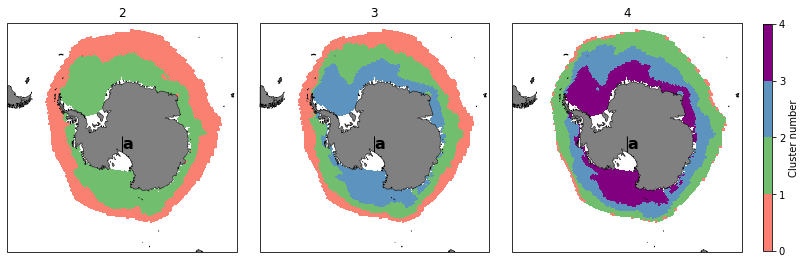

<Figure size 432x288 with 0 Axes>

In [8]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,5,1)
year = 2019
coord_lims = [-180, 180, -50, -90]
# Make a colormap
cmap = mpl.colors.ListedColormap([(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0), 'magenta'])

# define the bins and normalize
bounds = np.linspace(0, 4, 5)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)




land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                        edgecolor='black', facecolor='gray', linewidth=0.5)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=1,ncols=3,
                        subplot_kw={'projection': ccrs.SouthPolarStereo()},
                        figsize=(12,4.5))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

# Loop over number of clusters
for i,n_clusters in enumerate([2,3,4]):
        # Select the week 1 forecast from the specified model
        readfilename='/g/data/ia40/sea-ice-classification/kmean_'+str(n_clusters)+'_clusters_'+str(year)+'.nc'
        ds = xr.open_dataset(readfilename)
        data = ds['k'][243,:,:]
#        data=ds[model][0,:,:]

        # Add the cyclic point
#        data,lons=add_cyclic_point(data,coord=ds['LON'][0,:])
        lons = ds['LON'][:,:]
        lats = ds['LAT'][:,:]
        
        if n_clusters == 2:
            cmap_temp = mpl.colors.ListedColormap([(0.9805, 0.5000, 0.4453, 1.0),(0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0), 'magenta'])
            plot_data = ds['k'][243,:,:]
        elif n_clusters == 3:
            cmap_temp = mpl.colors.ListedColormap([(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0), 'magenta'])
            plot_data = ds['k'][243,:,:]
        elif n_clusters == 4:   
            cmap_temp = mpl.colors.ListedColormap([(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0), 'purple'])
            plot_data = ds['k'][243,:,:]
#            idx0 = plot_data == 0 
#            idx1 = plot_data == 1
#            idx2 = plot_data == 2
#            idx3 = plot_data == 3
#            plot_data[idx0] = 4
#            plot_data[idx1] = 0
#            plot_data[idx2] = 3
            
        
        # Plot the data
        cs=axs[i].pcolormesh(ds['LON'][:,:], ds['LAT'][:,:], plot_data,
                transform=ccrs.PlateCarree(),
                cmap=cmap_temp,
                norm=norm,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')

        # Title each subplot with the name of the model
        axs[i].set_title(str(n_clusters))
        
        axs[i].set_extent(coord_lims, ccrs.PlateCarree())
        
        axs[i].text(0.05, 0.95, 'a',fontsize=16, fontweight='bold', va='top') # , transform=ccrs.PlateCarree()

        # Draw the coastines for each subplot
#        axs[i].coastlines()
        
        # Add coastlines
#        axs[i].coastlines(resolution='50m')
        axs[i].add_feature(land_50m)

        # Longitude labels
        # axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        # lon_formatter = cticker.LongitudeFormatter()
        # axs[i].xaxis.set_major_formatter(lon_formatter)

#         # Latitude labels
#         axs[i].set_yticks(np.arange(-90,-30,30), crs=ccrs.PlateCarree())
#         lat_formatter = cticker.LatitudeFormatter()
#         axs[i].yaxis.set_major_formatter(lat_formatter)

# # Delete the unwanted axes
# for i in [7,8]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.0, top=0.9, left=0.05, right=0.9,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.925, 0.1, 0.01, 0.7])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical', label='Cluster number') 

# Add a big title at the top
#plt.suptitle('$k$-means performance for varying numbers of clusters')
# for label, ax in axs.items():
#     # label physical distance in and down:
#     trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
#     ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
#             fontsize='medium', verticalalignment='top', fontfamily='serif',
#             bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
#fig = plt.figure()
# for i, label in enumerate(('a', 'b', 'c')):
# #    ax = fig.add_subplot(2,2,i+1)
#     axs[i].text(0.05, 0.95, label, transform=ax.transAxes,
#       fontsize=16, fontweight='bold', va='top')

plt.show()

savepath = '/home/566/nd0349/notebooks/'
#plt.tight_layout()
plt.savefig(savepath+'kmeans_map_'+str(n_clusters)+'_clusters_'+str(year)+'.png', dpi = 300)  

In [ ]:
from cartopy.util import add_cyclic_point
import xarray as xr 
import cartopy.crs as ccrs 
import matplotlib.pyplot as plt 
import numpy as np

def add_cyclic_point_to_dataset(ds):
    # Load data
    data = ds["t2m"]

    # Generate data with cyclic point and generate longitude with cyclic point
    cyclic_data, cyclic_longitude = add_cyclic_point(data.values, coord=data['longitude'])

    # Create new coords that will be used in creation of new dataset
    # Replicate coords of existing dataset and replace longitude with cyclic longitude
    coords = {dim: data.coords[dim] for dim in data.dims}
    coords["longitude"] = cyclic_longitude

    new_ds = xr.Dataset(
        data_vars={
            "t2m": xr.DataArray(cyclic_data, dims=data.dims, coords=coords)
        })
    return new_ds 

new_ds = add_cyclic_point_to_dataset(ds)

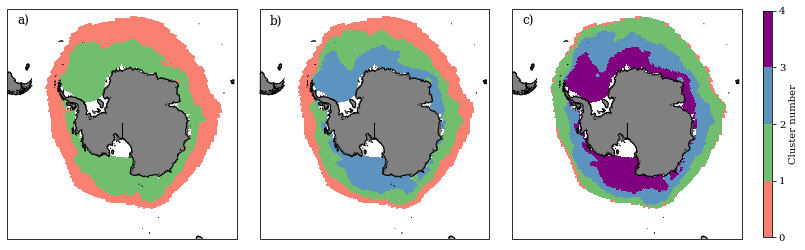

In [21]:
filename = '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-08-25.nc'
ds = xr.open_dataset(filename)
tmask = ds['tmask'][:,:]

# Define the contour levels to use in plt.contourf

clevs=np.arange(0,5,1)
year = 2019
coord_lims = [-180, 180, -50, -90]
# Make a colormap
cmap = mpl.colors.ListedColormap([(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0), 'purple'])

# define the bins and normalize
bounds = np.linspace(0, 4, 5)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Make the map
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                        edgecolor='black', facecolor='gray', linewidth=0.5)

fig, axs = plt.subplot_mosaic([['a)','b)', 'c)']],
                             # nrows=1,ncols=3,
                              subplot_kw={'projection': ccrs.SouthPolarStereo()},
                              figsize=(12,4.5))
plt.rcParams["font.family"] = "serif"
n_clusters = 2
for label, ax in axs.items():
    readfilename='/g/data/ia40/sea-ice-classification/kmean_'+str(n_clusters)+'_clusters_'+str(year)+'.nc'
    ds = xr.open_dataset(readfilename)
    plot_data = ds['k'][243,:,:]
    cs = ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:], plot_data,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
                norm=norm,
                shading='auto')

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='1.0', edgecolor='none', pad=3.0))
    ax.set_extent(coord_lims, ccrs.PlateCarree())
    
    # Add coastlines
    ax.add_feature(land_50m)
    ax.coastlines()
    n_clusters = n_clusters + 1

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.0, top=0.9, left=0.05, right=0.9,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.925, 0.1, 0.01, 0.7])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical', label='Cluster number') 


savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'kmeans_map_varying'+'_clusters_'+str(year)+'.png', dpi = 300)  
plt.show()
#import matplotlib2tikz
#matplotlib2tikz.save("miz_width_sector.tex")

In [5]:
## Variable selection

# Read in the data
savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
year = 2019
df_raw = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/raw_'+str(year)+'.csv')
df_standard = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/standard_'+str(year)+'.csv')
n_clusters = 3
kmeans = KMeans(
    init='random',#'k-means++',
    n_clusters=n_clusters,
#    n_init=1,
    n_init=10,
    max_iter=100,
#    random_state=1,#100,
    algorithm="lloyd",
    copy_x=True
)
print(str(n_clusters))
X_train = np.asarray(df_standard.iloc[:, [4]])
predicted = kmeans.fit(X_train)
#sort_idx = kmeans.cluster_centers_[:, 1].argsort()
#sort_idx = kmeans.cluster_centers_.argsort()
#kmeans.cluster_centers_ = kmeans.cluster_centers_[sort_idx]
predicted = kmeans.predict(X_train) 
print(kmeans.cluster_centers_)

df_kmeans = df_standard
df_kmeans['k'] = predicted

# Convert the dataframes to netcdf
print(str([1235]))
#df_read = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/'+'kmean_'+str(n_clusters)+'_clusters_'+str(year)+'.csv')
savefilename='/g/data/ia40/sea-ice-classification/kmean_'+str(n_clusters)+'_just_floesize_'+str(year)+'.nc'
mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
map_to_netcdf(df_kmeans,savefilename,mypath,year)

3
[[0.10859065]
 [0.55022154]
 [0.91710563]]
[1235]
Progress: [####################] 100% 
Progress: [####################] 100% 


In [12]:
df_standard.iloc[:, [4]]

,fsdrad
0,0.998791
1,0.999307
2,0.999141
3,0.999150
4,0.999237
...,...
2062806,0.005168
2062807,0.002695
2062808,0.002424
2062809,0.002373


In [11]:
# Removing floe size
print(str(n_clusters))
X_train = np.asarray(df_standard.iloc[:, [1,2,3,5]])
predicted = kmeans.fit(X_train)
#sort_idx = kmeans.cluster_centers_[:, 1].argsort()
#kmeans.cluster_centers_ = kmeans.cluster_centers_[sort_idx]
predicted = kmeans.predict(X_train) 
print(kmeans.cluster_centers_)

df_1235 = predicted

k_means_array_1235 = remap_df(lon,lat,df_1235[date_idx],date_idx)

3
[[0.7189817 ]
 [0.98480877]
 [0.24864054]]
Done!


In [4]:
def remap_df(lon,lat,k,date_idx):
    '''
    Remap dataframe to a netcdf grid.
    '''
    row_length = date_idx.sum()
    lon = lon.values.reshape(row_length,1)
    lat = lat.values.reshape(row_length,1)
    k = k.reshape(row_length,1)
    for row_lp in range(0, row_length):
        a = abs(LT-lat[row_lp])+abs(LN-lon[row_lp])
        i,j = np.unravel_index(a.argmin(),a.shape)
        k_means_array[i,j] = k[row_lp]
    print('Done!')

    return k_means_array

In [5]:
filename = '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2000-01-01.nc'
ds = xr.open_dataset(filename)
LN = ds.TLON.values
LT = ds.TLAT.values
n_clusters = 3
cmap = mpl.colors.ListedColormap([(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])#,'cyan','magenta'])
# define the bins and normalize
bounds = np.linspace(0, n_clusters, n_clusters+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
unique_dates = df_kmeans['date'].unique()
#tmp1, = unique_dates.shape
tmp1=1

tmp2, tmp3 = LN.shape
k_means_array = np.empty((tmp2,tmp3))
k_means_array[:] = np.nan

#date_length, = unique_dates.shape
date_length = tmp1
# Map the k values onto the grid
#for time_lp, date_tmp in enumerate(unique_dates):
date_tmp = unique_dates[243]
#progressBar = "\rProgress: " + ProgressBar(date_length, time_lp+1, 20, '#', '.')
#ShowBar(progressBar)
date_idx = df_kmeans['date'] == date_tmp

lon = df_kmeans['longitude'][date_idx];
lat = df_kmeans['latitude'][date_idx];

k_means_array_4 = remap_df(lon,lat,df_4[date_idx],date_idx)

k_means_array_14 = remap_df(lon,lat,df_14[date_idx],date_idx)

k_means_array_124 = remap_df(lon,lat,df_124[date_idx],date_idx)

k_means_array_1234 = remap_df(lon,lat,df_1234[date_idx],date_idx)

k_means_array_12345 = remap_df(lon,lat,df_12345[date_idx],date_idx)

Done!
Done!
Done!
Done!
Done!


In [66]:
#df_kmeans
#k_means_array_4 = remap_df(lon,lat,df_kmeans['4'][date_idx],date_idx)
#df_4
#date_idx.sum()
#df_1234[date_idx] - df_4[date_idx] #.reshape(row_length,1)

plot_data = [k_means_array_4, k_means_array_1, k_means_array_124-2, k_means_array_1234-5, k_means_array_12345, k_means_array_12345]
plot_data[0].shape

len(plot_data)

6

In [88]:
ds['k'][0,:,:]

<xarray.DataArray 'k' (nj: 300, ni: 360)>
[108000 values with dtype=float64]
Coordinates:
    LON      (nj, ni) float32 ...
    LAT      (nj, ni) float32 ...
    time     <U10 '2019-01-01'
Dimensions without coordinates: nj, ni
Attributes:
    long_name:  k-means_clusters
    units:      cluster number

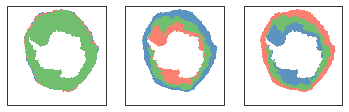

In [98]:
plt.figure()
coord_lims = [-180, 180, -50, -90]

readfilename='/g/data/ia40/sea-ice-classification/kmean_3_1_2019.nc'
ds = xr.open_dataset(readfilename)
plot_data = ds['k'][243,:,:]
ax = plt.subplot(1, 3, 1, projection=ccrs.SouthPolarStereo())
ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:],  plot_data,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            shading='auto') 
ax.set_extent(coord_lims, ccrs.PlateCarree())

readfilename='/g/data/ia40/sea-ice-classification/kmean_3_4_2019.nc'
ds = xr.open_dataset(readfilename)
plot_data = ds['k'][243,:,:]
ax = plt.subplot(1, 3, 2, projection=ccrs.SouthPolarStereo())
ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:],  plot_data,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            shading='auto') 
ax.set_extent(coord_lims, ccrs.PlateCarree())

readfilename='/g/data/ia40/sea-ice-classification/kmean_3_12345_2019.nc'
ds = xr.open_dataset(readfilename)
plot_data = ds['k'][243,:,:]
ax = plt.subplot(1, 3, 3, projection=ccrs.SouthPolarStereo())
ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:],  plot_data,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            shading='auto') 
ax.set_extent(coord_lims, ccrs.PlateCarree())

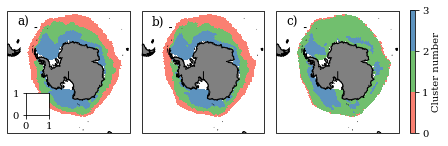

In [5]:
# Plot this on a map        
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,5,1)
year = 2019
coord_lims = [-180, 180, -50, -90]

# Make a colormap
cmap = mpl.colors.ListedColormap([(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
# define the bins and normalize
bounds = np.linspace(0, 3, 4)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Make the map
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                        edgecolor='black', facecolor='gray', linewidth=0.5)

fig, axs = plt.subplot_mosaic([['a)','b)','c)']],
                              subplot_kw={'projection': ccrs.SouthPolarStereo()},
                              figsize=(6.4, 3))
plt.rcParams["font.family"] = "serif"
n_clusters = 3
n_var = 0
for label, ax in axs.items():
    if label == 'a)':
        readfilename='/g/data/ia40/sea-ice-classification/kmean_3_12345_2019.nc'
        ds = xr.open_dataset(readfilename)
        plot_data = ds['k'][243,:,:]
        cmaptmp = cmap
    elif label == 'b)':
        readfilename='/g/data/ia40/sea-ice-classification/kmean_3_4_2019.nc'
        ds = xr.open_dataset(readfilename)
        plot_data = ds['k'][243,:,:]
        cmaptmp = mpl.colors.ListedColormap([(0.3639, 0.5755, 0.748, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.9805, 0.5000, 0.4453, 1.0)])
    elif label == 'c)':
        readfilename='/g/data/ia40/sea-ice-classification/kmean_3_1235_2019.nc'
        ds = xr.open_dataset(readfilename)
        plot_data = ds['k'][243,:,:]
        cmaptmp = cmap
        
#    print('yes')
    cs = ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:],  plot_data,
            transform=ccrs.PlateCarree(),
            cmap=cmaptmp,
            norm=norm,
            shading='auto')     

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='1.0', edgecolor='none', pad=3.0))
    ax.set_extent(coord_lims, ccrs.PlateCarree())

    # Add coastlines
    ax.add_feature(land_50m)
    ax.coastlines()


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.0, top=0.9, left=0.05, right=0.9,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.925, 0.165, 0.01, 0.57])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical', label='Cluster number') 



# Inset plots
n_days = 365
left, bottom, width, height = [0.06, 0.25, 0.04, 0.08]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(
    range(0,n_days,1),
    accuracy_sic,
    label=f"SIC",
    color="lightskyblue",
    linestyle="-",
    linewidth=2,
)
#ax2.set_xlabel('Strain (in/in)')
#ax2.set_ylabel('Accuracy')
#ax2.set_title('Inset of Elastic Region')
#ax2.set_xlim([0,0.008])
#ax2.set_ylim([0,1])



savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'kmeans_map_varying'+'_variables_'+str(year)+'.png', dpi = 600, bbox_inches='tight')  
plt.show()
#import matplotlib2tikz
#matplotlib2tikz.save("miz_width_sector.tex")

# ROC tests

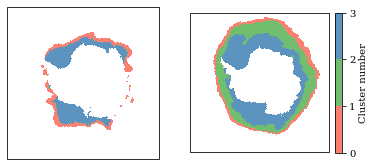

In [4]:
# Extract True MIZ
readfilename='/g/data/ia40/sea-ice-classification/kmean_2019.nc'
ds = xr.open_dataset(readfilename)
n_days, n_lat, n_lon = ds['k'].shape

MIZ_true = np.squeeze(np.reshape(ds['k'].values, (-1,1,1)))
idx = ~np.isnan(MIZ_true)
MIZ_true = MIZ_true[idx]
MIZ_true.shape
#MIZ_true

cmap = mpl.colors.ListedColormap([(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
# define the bins and normalize
bounds = np.linspace(0, 3, 4)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


plt.figure()
coord_lims = [-180, 180, -50, -90]
plot_data = ds['k'][-10,:,:]
ax = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
p = ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:],  plot_data,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            shading='auto') 
ax.set_extent(coord_lims, ccrs.PlateCarree())

plot_data = ds['k'][243,:,:]
ax = plt.subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())
p = ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:],  plot_data,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            shading='auto') 
ax.set_extent(coord_lims, ccrs.PlateCarree())
cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04, label='Cluster number') 

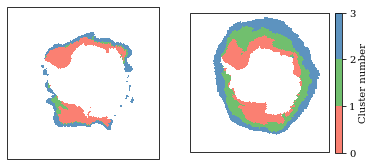

In [5]:
readfilename='/g/data/ia40/sea-ice-classification/kmean_3_4_2019.nc'
ds = xr.open_dataset(readfilename)
MIZ_floe = np.squeeze(np.reshape(ds['k'].values, (-1,1,1)))
MIZ_floe = MIZ_floe[idx]
MIZ_floe.shape


plt.figure()
coord_lims = [-180, 180, -50, -90]
plot_data = ds['k'][-10,:,:]
ax = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
p = ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:],  plot_data,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            shading='auto') 
ax.set_extent(coord_lims, ccrs.PlateCarree())

plot_data = ds['k'][243,:,:]
ax = plt.subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())
p = ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:],  plot_data,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            shading='auto') 
ax.set_extent(coord_lims, ccrs.PlateCarree())
cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04, label='Cluster number') 

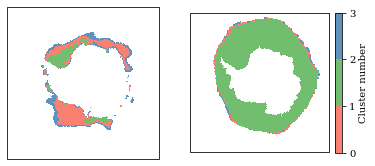

In [6]:
readfilename='/g/data/ia40/sea-ice-classification/kmean_3_1_2019.nc'
ds = xr.open_dataset(readfilename)
MIZ_sic = np.squeeze(np.reshape(ds['k'].values, (-1,1,1)))
MIZ_sic = MIZ_sic[idx]
MIZ_sic.shape

plt.figure()
coord_lims = [-180, 180, -50, -90]
plot_data = ds['k'][-10,:,:]
ax = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
p = ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:],  plot_data,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            shading='auto') 
ax.set_extent(coord_lims, ccrs.PlateCarree())

plot_data = ds['k'][243,:,:]
ax = plt.subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())
p = ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:],  plot_data,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            shading='auto') 
ax.set_extent(coord_lims, ccrs.PlateCarree())
cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04, label='Cluster number') 

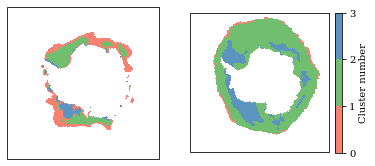

In [7]:
readfilename='/g/data/ia40/sea-ice-classification/kmean_3_1235_2019.nc'
ds = xr.open_dataset(readfilename)
MIZ_nofloe = np.squeeze(np.reshape(ds['k'].values, (-1,1,1)))
MIZ_nofloe = MIZ_nofloe[idx]
MIZ_nofloe.shape

plt.figure()
coord_lims = [-180, 180, -50, -90]
plot_data = ds['k'][-10,:,:]
ax = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
p = ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:],  plot_data,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            shading='auto') 
ax.set_extent(coord_lims, ccrs.PlateCarree())

plot_data = ds['k'][243,:,:]
ax = plt.subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())
p = ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:],  plot_data,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            shading='auto') 
ax.set_extent(coord_lims, ccrs.PlateCarree())
cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04, label='Cluster number') 

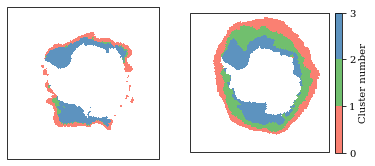

In [8]:
readfilename='/g/data/ia40/sea-ice-classification/kmean_3_124_2019.nc'
ds = xr.open_dataset(readfilename)
MIZ_124 = np.squeeze(np.reshape(ds['k'].values, (-1,1,1)))
MIZ_124 = MIZ_124[idx]
MIZ_124.shape

plt.figure()
coord_lims = [-180, 180, -50, -90]
plot_data = ds['k'][-10,:,:]
ax = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
p = ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:],  plot_data,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            shading='auto') 
ax.set_extent(coord_lims, ccrs.PlateCarree())

plot_data = ds['k'][243,:,:]
ax = plt.subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())
p = ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:],  plot_data,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            shading='auto') 
ax.set_extent(coord_lims, ccrs.PlateCarree())
cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04, label='Cluster number') 

In [90]:
y = MIZ_true
y_pred = MIZ_sic

print(f'accuracy score: {accuracy_score(y, y_pred)}')
cf_mat = confusion_matrix(y, y_pred)
print('Confusion matrix')
print(cf_mat)
print(f'class 0 accuracy: {cf_mat[0][0]/n_0}')
print(f'class 1 accuracy: {cf_mat[1][1]/n_1}')

accuracy score: 0.30917290217864385
Confusion matrix
[[ 77956 912819  16387]
 [ 34519 515849   8302]
 [ 78148 403748  56884]]
class 0 accuracy: 155.912
class 1 accuracy: 54.299894736842106


In [52]:
y = MIZ_true
y_pred = MIZ_124
y = MIZ_true == 0
y_pred = MIZ_124 == 0
print('124')
print(f'accuracy score: {accuracy_score(y, y_pred)}')
cf_mat = confusion_matrix(y, y_pred)
print('Confusion matrix')
print(cf_mat)
#print(f'class 0 accuracy: {cf_mat[0][0]/n_0}')
#print(f'class 1 accuracy: {cf_mat[1][1]/n_1}')


y = MIZ_true
y_pred = MIZ_sic
y = MIZ_true == 0
y_pred = MIZ_sic == 0
print('SIC')
print(f'accuracy score: {accuracy_score(y, y_pred)}')
cf_mat = confusion_matrix(y, y_pred)
print('Confusion matrix')
print(cf_mat)
#print(f'class 0 accuracy: {cf_mat[0][0]/n_0}')
#print(f'class 1 accuracy: {cf_mat[1][1]/n_1}')


y = MIZ_true
y_pred = MIZ_floe
y = MIZ_true == 0
y_pred = MIZ_floe == 2
print('Floe')
print(f'accuracy score: {accuracy_score(y, y_pred)}')
cf_mat = confusion_matrix(y, y_pred)
print('Confusion matrix')
print(cf_mat)
#print(f'class 0 accuracy: {cf_mat[0][0]/n_0}')
#print(f'class 1 accuracy: {cf_mat[1][1]/n_1}')

124
accuracy score: 0.8747317795394115
Confusion matrix
[[1600494  261017]
 [   2624  240477]]
SIC
accuracy score: 0.8666233966165735
Confusion matrix
[[1747397  114114]
 [ 166592   76509]]
Floe
accuracy score: 0.8538671261021034
Confusion matrix
[[1559895  301616]
 [   5937  237164]]


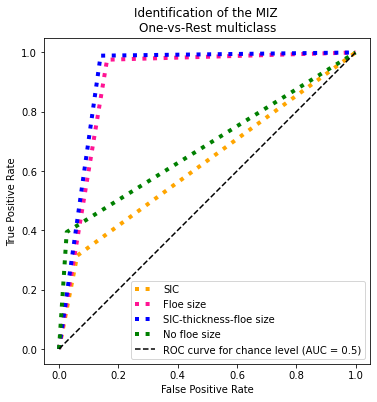

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
#from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(6, 6))
cluster_of_interest = 0
# SIC
y = MIZ_true == cluster_of_interest
pred = MIZ_sic == 0
fpr, tpr, thresholds = roc_curve(y, pred)
plt.plot(
    fpr,
    tpr,
    label=f"SIC",
    color="orange",
    linestyle=":",
    linewidth=4,
)

# Floe size
y = MIZ_true == cluster_of_interest
pred = MIZ_floe == 2 
fpr, tpr, thresholds = roc_curve(y, pred)
plt.plot(
    fpr,
    tpr,
    label=f"Floe size",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

# SIC, ice thickness, FSD
y = MIZ_true == cluster_of_interest
pred = MIZ_124 == 0
fpr, tpr, thresholds = roc_curve(y, pred)
plt.plot(
    fpr,
    tpr,
    label=f"SIC-thickness-floe size",
    color="blue",
    linestyle=":",
    linewidth=4,
)

# No floe size
y = MIZ_true == cluster_of_interest
pred = MIZ_nofloe == 0
fpr, tpr, thresholds = roc_curve(y, pred)
plt.plot(
    fpr,
    tpr,
    label=f"No floe size",
    color="green",
    linestyle=":",
    linewidth=4,
)


plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Identification of the MIZ \nOne-vs-Rest multiclass")
plt.legend()
plt.show()

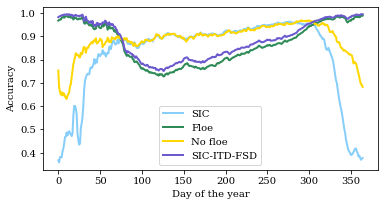

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

readfilename='/g/data/ia40/sea-ice-classification/kmean_2019.nc'
ds_true = xr.open_dataset(readfilename)

readfilename='/g/data/ia40/sea-ice-classification/kmean_3_1_2019.nc'
ds_sic = xr.open_dataset(readfilename)

readfilename='/g/data/ia40/sea-ice-classification/kmean_3_4_2019.nc'
ds_floe = xr.open_dataset(readfilename)

readfilename='/g/data/ia40/sea-ice-classification/kmean_3_1235_2019.nc'
ds_nofloe = xr.open_dataset(readfilename)

readfilename='/g/data/ia40/sea-ice-classification/kmean_3_124_2019.nc'
ds_124 = xr.open_dataset(readfilename)

accuracy_sic = np.empty((n_days))
accuracy_floe = np.empty((n_days))
accuracy_nofloe = np.empty((n_days))
accuracy_124 = np.empty((n_days))

for day_lp in range(0,n_days,1):
    n_days, n_lat, n_lon = ds['k'].shape

    MIZ_true = np.squeeze(np.reshape(ds_true['k'][day_lp,:,:].values, (-1,1,1)))
    idx = ~np.isnan(MIZ_true)
    MIZ_true = MIZ_true[idx]

    # SIC
    MIZ_sic = np.squeeze(np.reshape(ds_sic['k'][day_lp,:,:].values, (-1,1,1)))
    MIZ_sic = MIZ_sic[idx]
    
    y = MIZ_true == 0
    y_pred = MIZ_sic ==0
    accuracy_sic[day_lp] = accuracy_score(y, y_pred)
    
    # Floe
    MIZ_floe = np.squeeze(np.reshape(ds_floe['k'][day_lp,:,:].values, (-1,1,1)))
    MIZ_floe = MIZ_floe[idx]
    
    y = MIZ_true == 0
    y_pred = MIZ_floe == 2
    accuracy_floe[day_lp] = accuracy_score(y, y_pred)
    
    # No floe size
    MIZ_nofloe = np.squeeze(np.reshape(ds_nofloe['k'][day_lp,:,:].values, (-1,1,1)))
    MIZ_nofloe = MIZ_nofloe[idx]
    
    y = MIZ_true == 0
    y_pred = MIZ_nofloe == 0
    accuracy_nofloe[day_lp] = accuracy_score(y, y_pred)
    
    # 124
    MIZ_124 = np.squeeze(np.reshape(ds_124['k'][day_lp,:,:].values, (-1,1,1)))
    MIZ_124 = MIZ_124[idx]
    
    y = MIZ_true == 0
    y_pred = MIZ_124 == 0
    accuracy_124[day_lp] = accuracy_score(y, y_pred)
    
plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots(figsize=(6, 3))

# SIC
plt.plot(
    range(0,n_days,1),
    accuracy_sic,
    label=f"SIC",
    color="lightskyblue",
    linestyle="-",
    linewidth=2,
)

plt.plot(
    range(0,n_days,1),
    accuracy_floe,
    label=f"Floe",
    color="seagreen",
    linestyle="-",
    linewidth=2,
)

plt.plot(
    range(0,n_days,1),
    accuracy_nofloe,
    label=f"No floe",
    color="gold",
    linestyle="-",
    linewidth=2,
)

plt.plot(
    range(0,n_days,1),
    accuracy_124,
    label=f"SIC-ITD-FSD",
    color="slateblue",
    linestyle="-",
    linewidth=2,
)


plt.xlabel("Day of the year")
plt.ylabel("Accuracy")
#plt.ylim([0,1])
#plt.title("Identification of the MIZ \nOne-vs-Rest multiclass")
plt.legend()

savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'accuracy_ts_'+'2019'+'.png', dpi = 600)  
plt.show()
#import matplotlib2tikz
#matplotlib2tikz.save("miz_width_sector.tex")


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


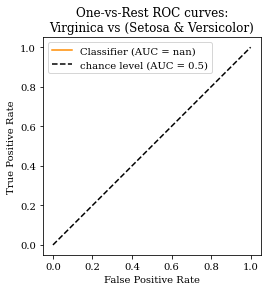

In [32]:




import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
   # name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [ ]:
# ROC curve
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

In [ ]:
clevs=np.arange(0,5,1)
year = 2019
coord_lims = [-180, 180, -50, -90]

# Make the map
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                        edgecolor='black', facecolor='gray', linewidth=0.5)

# fig, axs = plt.subplot_mosaic([['a)','b)','c)','d)','e)']],
#                               subplot_kw={'projection': ccrs.SouthPolarStereo()},
#                               figsize=(12,4.5))
fig, axs = plt.subplot(1,4)
plt.rcParams["font.family"] = "serif"
n_clusters = 3
n_var = 0
#for label, ax in axs.items():
print(n_var)
cs = axs[0].pcolormesh(ds['TLON'][:,:], ds['TLAT'][:,:],  plot_data[0],
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=norm,
        shading='auto')  

cs = axs[1].pcolormesh(ds['TLON'][:,:], ds['TLAT'][:,:],  plot_data[1],
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=norm,
        shading='auto')  

# label physical distance in and down:
# trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
# ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
#         fontsize='large', verticalalignment='top', fontfamily='serif',
#         bbox=dict(facecolor='1.0', edgecolor='none', pad=3.0))
ax.set_extent(coord_lims, ccrs.PlateCarree())

# Add coastlines
ax.add_feature(land_50m)
ax.coastlines()
n_var = n_var + 1

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.0, top=0.9, left=0.05, right=0.9,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.925, 0.1, 0.01, 0.7])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical', label='Cluster number') 


savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'kmeans_map_varying'+'_variables_'+str(year)+'.png', dpi = 300)  
plt.show()
#import matplotlib2tikz
#matplotlib2tikz.save("miz_width_sector.tex")

In [45]:
axs

{'a)': <GeoAxesSubplot:label='a)'>,
 'b)': <GeoAxesSubplot:label='b)'>,
 'c)': <GeoAxesSubplot:label='c)'>,
 'd)': <GeoAxesSubplot:label='d)'>,
 'e)': <GeoAxesSubplot:label='e)'>}

In [54]:
# print(np.nanmin(k_means_array_4[:,:] - k_means_array_12345[:,:]))
# print(np.nanmax(k_means_array_4[:,:] - k_means_array_12345[:,:]))

# #df_kmeans
# k_means_array_4

for label, ax in axs.items():
    print(label)
    print(ax)
    if label == 'a)':
        print('yes')

a)
< GeoAxes: +proj=stere +ellps=WGS84 +lat_0=-90 +lon_0=0.0 +x_0=0.0 +y_0=0.0 +no_defs +type=crs >
yes
b)
< GeoAxes: +proj=stere +ellps=WGS84 +lat_0=-90 +lon_0=0.0 +x_0=0.0 +y_0=0.0 +no_defs +type=crs >
c)
< GeoAxes: +proj=stere +ellps=WGS84 +lat_0=-90 +lon_0=0.0 +x_0=0.0 +y_0=0.0 +no_defs +type=crs >
d)
< GeoAxes: +proj=stere +ellps=WGS84 +lat_0=-90 +lon_0=0.0 +x_0=0.0 +y_0=0.0 +no_defs +type=crs >
e)
< GeoAxes: +proj=stere +ellps=WGS84 +lat_0=-90 +lon_0=0.0 +x_0=0.0 +y_0=0.0 +no_defs +type=crs >
